<a href="https://colab.research.google.com/github/ialara/actf/blob/f22-reforge/f22_reforge_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Guts

## Imports

The fewer and more mainstream the imports, the less likely to cause headaches on AF systems.

In [65]:
import numpy as np
from collections import Counter
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import datetime
from itertools import chain
rng = np.random.default_rng()

In [66]:
mds_name = 'F-22'
mds_sorties_from_ftu = 15 # Count toward experiencing. Based on FTU syllabus rides.

#############################
## Squadron Initialization ##
#############################
# Uniform draw
init_sq_inx_tos_min = 0
init_sq_inx_tos_max = 36
init_sq_exp_tos_min = 0
init_sq_exp_tos_max = 36

# Uniform draw, capped by TOS/SCM dependency.
init_sq_inx_mds_sorties_min = mds_sorties_from_ftu
init_sq_inx_scm_limit = 9 # Assume upper bound of x sorties per month on station
init_sq_inx_mds_sorties_max = 350 # used to be -> init_sq_inx_mds_sorties_min + init_sq_inx_scm_limit*init_sq_inx_tos_max 

# Uniform draw
####################################################
## REDUCED TO 62% OF ORIGINAL BASED ON REFORGE CONOP
####################################################
init_sq_exp_mds_sorties_min = 155 # <-- setting based on Syllabus.exp_sortie_rqmt breaks if exploring definition with no sortie minimum
init_sq_exp_mds_sorties_max = 248 # Arbitrary ub
init_ip_mds_sorties_min = 176 # EXP pilots meeting minimum x MDS sorties are assigned as IPs up to initial IP count.
####################################################
init_mqt_complete_tos_min = 2 # Assumes initial pilots complete MQT within specified timeline (of x months). Pilots < x TOS are enrolled in MQT (up to capacity).

#############################
## Inflow Pilot Parameters ##
#############################
ftu_inflow_mds_sortie_plus_minus = 2 # from FTU sortie parameter.
####################################################
## REDUCED TO 60% OF ORIGINAL BASED ON REFORGE CONOP
####################################################
xflow_WG_mds_sorties_min = 120
xflow_WG_mds_sorties_max = 144 # (90% of original EXP 250 sortie minimum)
xflow_2FL_mds_sorties_min = xflow_WG_mds_sorties_max
xflow_2FL_mds_sorties_max = 180
xflow_4FL_mds_sorties_min = xflow_2FL_mds_sorties_max
xflow_4FL_mds_sorties_max = 300
xflow_IP_mds_sorties_min = 180
xflow_IP_mds_sorties_max = 300
####################################################
xflow_IP_pct = 0.2
xflow_WG_pct = 0.2

##########################################
## Upgrade Enrollment Probability Ramps ##
##########################################
# A measure of CC discretion in determining when pilots are "ready" to start
# various upgrades. At each MDS sortie "chunk" a pilot has a certain chance of
# enrollment into the upgrade (assuming available space). As pilots accumulate
# sorties to put them into the next "chunk," their enrollment probability increases
# (they are more likely to be "ready"), up to a defined maximum chance. Note, the
# simulation separately constrains simultaneous upgrade enrollment to a certain 
# program capacity -- this input should only capture the "readiness"/aptitude of
# a pilot based roughly on their MDS sorties.
#
# For example, one way to think of it is "50% of WGs with 200-229 sorties are ready to start FLUG,"
# "80% of WGs with 260-299 sorties are ready to start FLUG." Alternatively,
# "each WG with 200-229 sorties has a 50% chance of being deemed ready for FLUG,"
# "each WG with 260-299 sorties has an 80% chance of being deemed ready for FLUG."
# Statistically, these inputs define the discrete **monthly** cdf of the upgrade readiness probability distribution.

#####################################################
# Reduced to CONOP start targets
######################################################
min_mds_sorties_2flug = 85
enrolment_prob_at_minimum_2flug = 0.3
sortie_chunk_size_2flug = 10
enrolment_prob_increment_per_chunk_2flug = 0.05
enrolment_prob_max_2flug = 0.99

min_mds_sorties_4flug = 145
enrolment_prob_at_minimum_4flug = 0.3
sortie_chunk_size_4flug = 10
enrolment_prob_increment_per_chunk_4flug = 0.05
enrolment_prob_max_4flug = 0.99

min_mds_sorties_ipug = 245 # Assumed same 30% reduction for 4FLUG.
enrolment_prob_at_minimum_ipug = 0.3
sortie_chunk_size_ipug = 10
enrolment_prob_increment_per_chunk_ipug = 0.05
enrolment_prob_max_ipug = 0.4



###########################
## Syllabus Refly Rates  ##
###########################
# A measure of refly rates due to student proficiency only (i.e., wx/mx cancellations
# are accounted for separately). Expressed as %, e.g. 0.1 means 10% of upgrade sorties
# will be reflown on average.
mqt_refly_rate = 0.1
two_flug_refly_rate = 0.2
four_flug_refly_rate = 0.2
ipug_refly_rate = 0.2

###########################
## Sortie Attrition Rate ##
###########################
# A generic measure to reduce the "bottom-line" sortie generation (post-attrition).
# The sortie generation for the month will average:
# (turn_pattern)*(monthly_fly_days)*(1-sortie_attrition_pct)
# Should be between 0 and 1.
# TODO: Expand functionality to allow variation by month, or maybe a calculation.
sortie_attrition_pct = 0.15

###########################
## Time-on-station limit ##
###########################
tos_limit_months = 36

#####################################
## Absorption Importance (% tails) ##
#####################################
## NOT IMPLEMENTED
daily_INX_tails_pct = 0.3

In [67]:
class Pilot:
    ftu_sorties = mds_sorties_from_ftu # Sortie Flow F-22 xlsx
    def __init__(self, i, mds_sorties=mds_sorties_from_ftu, tos=0, experienced=False):
        self.id = i
        self.mds_sorties = mds_sorties
        self.tos = tos
        self.experienced = experienced
        self.arrived_month = 0
        self.in_ug = False
        self.ug = None
        self.ride_num = None
        self.quals = []
        self.ttfl = 0

    def set_arrived_month(self, month):
        self.arrived_month = month

    def set_max_scm(self, scm):
        self.max_scm = scm

    def increment_tos(self, months=1):
        self.tos += months

    def increment_mds_sorties(self, sortie_increment=1, is_ug=False, num_reflies=None):
        self.mds_sorties += sortie_increment
        if is_ug:
          assert self.in_ug, "Pilot not in upgrade, cannot increment ug sorties"
          assert num_reflies is not None, "Specify upgrade reflies"
          # refly_draws = rng.random(size=sortie_increment)
          # num_reflies = np.sum(refly_draws < refly_rate)
          self.ride_num += sortie_increment - num_reflies

    def enroll_in_ug(self, ug, start_month=0):
        if self.in_ug:
            #print(f'PID {self.id} already enrolled in {self.ug}. {f"Did not enroll in {ug}." if self.ug != ug else ""}')
            return
        self.in_ug = True
        self.ug = ug
        self.ug_start_month = start_month
        self.ride_num = 0
        self.start_sorties = self.mds_sorties
        #print(f'PID {self.id} enrolled in {self.ug}.')
      
    def disenroll_from_ug(self):
        self.in_ug = False
        self.ug = None
        self.ride_num = None
        self.start_sorties = None

    def award_qual(self, qual):
        if qual not in self.quals:
            self.quals.append(qual)

    def print_(self):
        msg = [f'ID: {self.id:2d} | EXP: {"Y" if self.experienced else "N"} | ',
               f'TOS: {self.tos:2d} | STY: {self.mds_sorties:3d} | ARR: {self.arrived_month:3d} | ',
               f'SCM: {self.max_scm:2d} ({"Atch/BMC" if self.max_scm == bmc_scm_max else "Asgn/CMR"}) | ',
               f'TTFL: {self.ttfl if self.experienced else "- ":2} | QUAL: {self.quals}']
        if self.ug is not None:
            msg.append(f' | UG: {self.ug} #{self.ride_num}')

        print(*msg)
    
    def __str__(self):
        msg = [f'ID: {self.id:2d} | EXP: {"Y" if self.experienced else "N"} | ',
               f'TOS: {self.tos:2d} | STY: {self.mds_sorties:3d} | ARR: {self.arrived_month:3d} | ',
               f'TTFL: {self.ttfl if self.experienced else "- ":2} | QUAL: {self.quals}']
        if self.ug is not None:
            msg.append(f' | UG: {self.ug} #{self.ride_num}')

        return str(msg)


class Squadron:
    def __init__(self, name='default_Squadron', syllabi=None):
        self.name = name
        self.pilots = []
        self.gone_pilots = []
        self.absorbed_pilots = []
        self.pid = 0
        if syllabi is None:
            self.syllabi = {}
        else:
            self.syllabi = syllabi

    def assign_pilot(self, pilot, arrived_month=0):
        self.pilots.append(pilot)
        pilot.set_arrived_month(arrived_month)

    def add_syllabi(self, syllabi):
        self.syllabi = syllabi

    def set_syllabus_ug_capacity(self, syllabus, capacity):
        syllabus.capacity = capacity

    def set_monthly_sorties_available(self, capacity=240):
        self.monthly_sorties_available = capacity

    def _next_pid(self):
        self.pid += 1
        return self.pid

    def get_pilot_by_id(self, id):
        pilot_dict = {p.id: p for p in self.pilots}
        pilot_dict.update({p.id: p for p in self.gone_pilots})
        return pilot_dict[id]

    def get_pilots_by_qual(self):
        quals = np.asarray(self._get_highest_quals())
        pilots = np.asarray(self.pilots)
      
        return {q: list(pilots[quals == q]) for q in Counter(quals).keys()}


    def populate_initial(self, num_pilots=25, prop_EXP=0.6, prop_IP=0.3, num_attached=5, attached_IP_pct=0.6):
        # num_EXP = rng.binomial(num_pilots, prop_EXP)
        # num_IP = rng.binomial(num_EXP, prop_IP)
        # num_INX = num_pilots - num_EXP

        # Assigned
        num_EXP = int(num_pilots*prop_EXP) 
        num_IP = int(num_pilots*prop_IP)
        num_INX = num_pilots - num_EXP

        # Attached
        num_attached_IP = int(num_attached*attached_IP_pct)

        # Parameters
        min_TOS_INX = init_sq_inx_tos_min
        max_TOS_INX = init_sq_inx_tos_max
        min_TOS_EXP = init_sq_exp_tos_min
        max_TOS_EXP = init_sq_exp_tos_max

        min_sorties_INX = init_sq_inx_mds_sorties_min
        max_sorties_INX = init_sq_inx_mds_sorties_max
        min_sorties_EXP = init_sq_exp_mds_sorties_min
        max_sorties_EXP = init_sq_exp_mds_sorties_max

        max_scm_assigned = cmr_scm_max
        max_scm_attached = bmc_scm_max

        # Assign INX pilots
        for _ in range(num_INX):
            my_tos = rng.integers(min_TOS_INX, max_TOS_INX)
            my_sorties = rng.integers(min_sorties_INX, max_sorties_INX)
            # Rough capping of sorties w/ TOS: Assume no more than x sorties per month
            # (Assume no "holdover" INX arrivals in initial population)
            my_sorties = min(my_sorties, min_sorties_INX + (my_tos+1)*init_sq_inx_scm_limit)
            inx_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos)
            inx_pilot.initial_tos = my_tos # Debugging initial population

            inx_pilot.inflow_source = 'initial'
            inx_pilot.absorbable = True
            if inx_pilot.tos > init_mqt_complete_tos_min: # Assume initial population completes MQT in specified timeline, and represents only first tour arrivals
                inx_pilot.increment_mds_sorties(self.syllabi['MQT'].duration, is_ug=False)
                inx_pilot.award_qual(self.syllabi['MQT'].award)
                inx_pilot.inflow_source += f' {self.syllabi["MQT"].award}'
                two_fl_draw = rng.random()
                if (inx_pilot.mds_sorties >= min_mds_sorties_2flug + self.syllabi['2FLUG'].duration) and (rng.random() <
            min(enrolment_prob_at_minimum_2flug + int((inx_pilot.mds_sorties - min_mds_sorties_2flug) / sortie_chunk_size_2flug)*enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug)):
                    inx_pilot.award_qual(self.syllabi['2FLUG'].award)
                    inx_pilot.inflow_source += f'/{self.syllabi["2FLUG"].award}'

            else: # These are new arrivals - assume all initial INX with 0 or 1 TOS
                  # are from FTU
                my_ug_prog = rng.integers(self.syllabi['MQT'].duration) # MQT and FLUG have same duration
                # Assumptions: INX arrivals with 0 or 1 TOS are either new from FTU,
                # or "hold-overs" arriving INX from previous location
                ##if inx_pilot.f16_sorties < 75:
                inx_pilot.enroll_in_ug('MQT')
                #self.syllabi['MQT'].capacity -= 1
                inx_pilot.increment_mds_sorties(my_ug_prog, num_reflies=0)
                # elif inx_pilot.f16_sorties < 200:
                #     inx_pilot.award_qual('WG')
                #     inx_pilot.inflow_source += ' WG'
                #     if rng.random() < 0.7:
                #         inx_pilot.enroll_in_ug('FLUG')
                #         #self.syllabi['FLUG'].capacity -= 1
                #         inx_pilot.increment_f16_sorties(my_ug_prog)
                #         inx_pilot.inflow_source += '/FLUG'

                # else:
                #     inx_pilot.award_qual('WG')
                #     if rng.random() < 0.7:
                #         inx_pilot.award_qual('FL')
                #         inx_pilot.inflow_source += ' FL'
            inx_pilot.set_max_scm(max_scm_assigned)
            self.assign_pilot(inx_pilot, arrived_month=-1*inx_pilot.tos)
          
        # Assign EXP pilots
        ips_remaining = num_IP
        for _ in range(num_EXP):
            my_tos = rng.integers(min_TOS_EXP, max_TOS_EXP)
            my_sorties = rng.integers(min_sorties_EXP, max_sorties_EXP)
            exp_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos,
                              experienced = True)
            exp_pilot.award_qual(Syllabus.exp_qual_rqmt)
            exp_pilot.absorbable = False
            exp_pilot.inflow_source = 'initial EXP'
            if exp_pilot.mds_sorties >= init_ip_mds_sorties_min and ips_remaining > 0: #275 based on Slab desired changes + 9 for IPUG -- make a parameter
                exp_pilot.award_qual('IP')
                ips_remaining -= 1
            exp_pilot.inflow_source = 'initial EXP/IP'
            # elif exp_pilot.f16_sorties >= 275:
            #     ipug_prob = min(1, 0.6 + int((exp_pilot.f16_sorties - 275)/30)*.15)
            #     if rng.random() < ipug_prob:
            #       exp_pilot.enroll_in_ug('IPUG')
            #       #self.syllabi['IPUG'].capacity -= 1
            #       exp_pilot.increment_f16_sorties(rng.integers(9))
            exp_pilot.initial_tos = my_tos
            exp_pilot.set_max_scm(max_scm_assigned)
            self.assign_pilot(exp_pilot, arrived_month=-1*exp_pilot.tos)

        # Include attached pilots
        ips_remaining = num_attached_IP
        for _ in range(num_attached):
          my_tos = rng.integers(min_TOS_EXP, max_TOS_EXP)
          my_sorties = rng.integers(min_sorties_EXP, max_sorties_EXP)
          exp_pilot = Pilot(self._next_pid(), mds_sorties=my_sorties, tos=my_tos,
                              experienced = True)
          exp_pilot.award_qual(Syllabus.exp_qual_rqmt)
          exp_pilot.absorbable = False
          exp_pilot.inflow_source = 'initial attached EXP'
          if exp_pilot.mds_sorties >= init_ip_mds_sorties_min and ips_remaining > 0: #275 based on Slab desired changes + 9 for IPUG -- make a parameter
              exp_pilot.award_qual('IP')
              ips_remaining -= 1
          exp_pilot.inflow_source = 'initial attached EXP/IP'
          # elif exp_pilot.f16_sorties >= 275:
          #     ipug_prob = min(1, 0.6 + int((exp_pilot.f16_sorties - 275)/30)*.15)
          #     if rng.random() < ipug_prob:
          #       exp_pilot.enroll_in_ug('IPUG')
          #       #self.syllabi['IPUG'].capacity -= 1
          #       exp_pilot.increment_f16_sorties(rng.integers(9))
          exp_pilot.initial_tos = my_tos
          exp_pilot.set_max_scm(max_scm_attached)
          self.assign_pilot(exp_pilot, arrived_month=-1*exp_pilot.tos)



    def inflow_from_ftu(self, num_pilots=15, arrival_month=0):
        new_ftus = []
        for _ in range(num_pilots):
            ftu_sortie_delta = rng.integers(-1*ftu_inflow_mds_sortie_plus_minus, ftu_inflow_mds_sortie_plus_minus)
            my_mds_sorties = Pilot.ftu_sorties + ftu_sortie_delta
            new_pilot = Pilot(self._next_pid(), mds_sorties = my_mds_sorties)
            new_pilot.inflow_source = 'FTU'
            new_pilot.absorbable = True
            new_pilot.set_max_scm(cmr_scm_max)
            self.assign_pilot(new_pilot, arrived_month=arrival_month)
            new_ftus.append(new_pilot)
        
        return new_ftus

    def inflow_nth_tour(self, num_pilots=20, prop_IP=xflow_IP_pct, prop_WG=xflow_WG_pct, arrival_month=0):
        num_IP = rng.binomial(num_pilots, prop_IP)
        num_WG = rng.binomial(num_pilots, prop_WG)
        num_4FL = num_pilots - num_IP - num_WG

        # Parameters
        min_sorties_WG = xflow_WG_mds_sorties_min
        max_sorties_WG = xflow_WG_mds_sorties_max
        min_sorties_4FL = xflow_4FL_mds_sorties_min
        max_sorties_4FL = xflow_4FL_mds_sorties_max
        min_sorties_IP = xflow_IP_mds_sorties_min
        max_sorties_IP = xflow_IP_mds_sorties_max

        new_nth = []

        def _decide_cmr_bmc(attached_prop=init_attached_pilots / initial_pilots):
            draw = rng.random()
            if draw <= attached_prop:
              scm = bmc_scm_max
            else:
              scm = cmr_scm_max

            return scm

        for _ in range(num_IP):
            my_sorties = rng.integers(min_sorties_IP, max_sorties_IP)
            new_IP = Pilot(self._next_pid(), mds_sorties = my_sorties, experienced=True)
            new_IP.award_qual(Syllabus.exp_qual_rqmt)
            new_IP.inflow_source = 'nth tour'
            new_IP.award_qual('IP')
            new_IP.set_max_scm(_decide_cmr_bmc())
            self.assign_pilot(new_IP, arrived_month=arrival_month)
            new_IP.absorbable = False
            new_nth.append(new_IP)

        for _ in range(num_4FL):
            my_sorties = rng.integers(min_sorties_4FL, max_sorties_4FL)
            new_4FL = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_4FL.award_qual('4FL')
            new_4FL.experienced = Syllabus.meets_EXP_criteria(new_4FL.mds_sorties, new_4FL.quals)
            new_4FL.inflow_source = 'nth tour'
            new_4FL.set_max_scm(_decide_cmr_bmc())
            self.assign_pilot(new_4FL, arrived_month=arrival_month)
            new_4FL.absorbable = False
            new_nth.append(new_4FL)

        for _ in range(num_WG):
            my_sorties = rng.integers(min_sorties_WG, max_sorties_WG)
            new_WG = Pilot(self._next_pid(), mds_sorties = my_sorties)
            new_WG.award_qual('WG')
            new_WG.inflow_source = 'nth tour'
            new_WG.absorbable = False
            new_WG.set_max_scm(cmr_scm_max)
            self.assign_pilot(new_WG, arrived_month=arrival_month)
            new_nth.append(new_WG)

        attached_proportion = init_attached_pilots / initial_pilots

        
        return new_nth
            
    def inflow_pilots(self, num_ftu=15, num_nth_tour=5, arrival_month=0):
        new_ftus = self.inflow_from_ftu(num_ftu, arrival_month=arrival_month)
        new_nth = self.inflow_nth_tour(num_nth_tour, arrival_month=arrival_month)
        try:
            ips = self.get_pilots_by_qual()['IP']
            for p in ips:
                assert p.experienced, f'IP {p.id} is not experienced.'
        except KeyError:
             pass
        return new_ftus, new_nth

    def outflow_pilots(self, tos_threshold=36):
        removed_pilots = [p for p in self.pilots if p.tos >= tos_threshold]
        for p in removed_pilots:
            if p.absorbable:
                p.absorbed = False
        self.pilots = [p for p in self.pilots if p not in set(removed_pilots)]
        self.gone_pilots.extend(removed_pilots)
        return removed_pilots

    def enroll_ug_students(self, start_month=0):
        pilots_by_quals = self.get_pilots_by_qual()
        enrolled_numbers = self.summarize()['UPGS']

        def _find_candidates(qual_prereq):
            candidates = []
            try:
                candidates = [p for p in pilots_by_quals[qual_prereq] if not p.in_ug]
            except KeyError:
                #print(f'Could not find any {qual_prereq}. Returning: {candidates}')
                pass
            return candidates

        mqt_candidates = _find_candidates('')
        two_flug_candidates = _find_candidates(self.syllabi['MQT'].award)
        two_flug_candidates = [p for p in two_flug_candidates if (p.mds_sorties >= min_mds_sorties_2flug) and (rng.random() <
            min(enrolment_prob_at_minimum_2flug + int((p.mds_sorties - min_mds_sorties_2flug) / sortie_chunk_size_2flug)*enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug))]
        four_flug_candidates = _find_candidates(self.syllabi['2FLUG'].award)
        four_flug_candidates = [p for p in four_flug_candidates if p.mds_sorties >= min_mds_sorties_4flug and (rng.random() <
            min(enrolment_prob_at_minimum_4flug + int((p.mds_sorties - min_mds_sorties_4flug) / sortie_chunk_size_4flug)*enrolment_prob_increment_per_chunk_4flug, enrolment_prob_max_4flug))]
        ipug_candidates = _find_candidates(self.syllabi['4FLUG'].award)
        ipug_candidates = [p for p in ipug_candidates if p.experienced and p.mds_sorties >= min_mds_sorties_ipug and (rng.random() <
            min(enrolment_prob_at_minimum_ipug + int((p.mds_sorties - min_mds_sorties_ipug) / sortie_chunk_size_ipug)*enrolment_prob_increment_per_chunk_ipug, enrolment_prob_max_ipug))]
            
        # Prioritize students (e.g. by TOS for MQT; sorties for FLUG/IPUG)
        mqt_candidates.sort(key=lambda x: (x.tos, x.mds_sorties), reverse=True)
        two_flug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        four_flug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        ipug_candidates.sort(key=lambda x: x.mds_sorties, reverse=True)
        # Enroll as many as possible, subject to capacity of upgrade program
        for students, program in zip([mqt_candidates, two_flug_candidates, four_flug_candidates, ipug_candidates],
                                     [self.syllabi['MQT'], self.syllabi['2FLUG'], self.syllabi['4FLUG'], self.syllabi['IPUG']]):
          # TODO: Note this is not guaranteed if programs have different capacities
          # (self.syllabi.values() order returned is random)
            try:
              already_enrolled = enrolled_numbers[program.name]
            except KeyError:
              already_enrolled = 0
            spots_available = program.capacity - already_enrolled
            enrollees = students[:spots_available]
            for e in enrollees:
              e.enroll_in_ug(program.name, start_month=start_month)

    def fly_month(self, sorties_available=None, INX_tails_pct=daily_INX_tails_pct, fly_days=20):
        if sorties_available is None:
            sorties_available = self.monthly_sorties_available
        #INX_sorties = int(sorties_available * INX_sortie_pct)
        for p in self.pilots:
            p.scm = 0
        INX_pilots = [p for p in self.pilots if not p.experienced]

        rng.shuffle(INX_pilots)
        sorties_remaining = sorties_available
        inx_sorties_flown = 0
        inx_support_sorties_flown = 0
        non_absorption_sorties = 0
        # Essentially the theoretical SCM limit, accounting for student non-availability
        daily_inx_tails = min(len(INX_pilots), int((sorties_available / fly_days)*INX_tails_pct)) # Up to INX_tails_pct proportion of PMAI dedicated to absorbing pilot (MQT or WG).
        
        pilots_by_qual = self.get_pilots_by_qual()

        ups = [p for p in self.pilots if p.in_ug]
        rng.shuffle(ups)

        def _prioritize_ugs(ug):
          ug_priorities = {'MQT': 0,
                           'IPUG': 1,
                           '2FLUG': 2,
                           '4FLUG': 3}
          return ug_priorities[ug]

        def _assign_ug_support(support_burden, num_flights, up_id):
          flights_supportable = num_flights # used to limit number of support sorties based on support qual inventory
          spt_chosen = [] # pilots that will fly support

          # Determine number of supportable UP sorties
          for k, v in support_burden.items():
             spt_requested = int(np.ceil(v*num_flights))
             try:
               spt_pilots = [p for p in pilots_by_qual[k] if p.id != up_id]
             except KeyError:
               spt_pilots = []
             spt_pool = []
             for p in spt_pilots:
                 scm_remaining = int(min(p.max_scm - p.scm, num_flights)) # each support pilot can fly once per UP flight, up to max SCM.
                 spt_pool.extend([p]*scm_remaining) # replicate unique pilots by # of fly days available
             if len(spt_pool) < spt_requested: # cannot fly all sorties requested
                spt_avail = len(spt_pool) // v # can only support this amount of flights
                flights_supportable = min(flights_supportable, spt_avail)

          # Assign support
          for k, v in support_burden.items():
             try:
               spt_pilots = [p for p in pilots_by_qual[k] if p.id != up_id]
             except KeyError:
               spt_pilots = []
             spt_pool = []
             for p in spt_pilots:
                 scm_remaining = int(min(p.max_scm - p.scm, flights_supportable)) # each support pilot can fly once per UP flight, up to max SCM.
                 spt_pool.extend([p]*scm_remaining) # replicate unique pilots by # of fly days available
             num_to_choose = int(np.ceil(v*flights_supportable))
             spt_chosen.extend(list(rng.choice(spt_pool, size=num_to_choose, replace=False)))
          
          return flights_supportable, spt_chosen

        def _assign_inx_ct_support(num_flights, inx_id):
            flights_supportable = num_flights
            support = []
            for spt_qual in ['IP', '2FL', '4FL']:
              try:
                spt_pilots = pilots_by_qual[spt_qual]
                for p in spt_pilots:
                  support.extend([p]*min(flights_supportable, p.max_scm - p.scm))
              except KeyError:
                pass
            support = [spt for spt in support if spt.id != inx_id]
            flights_supportable = min(flights_supportable, len(support))
            support = rng.choice(support, size=flights_supportable, replace=False)

            return flights_supportable, support
             
        


        def _is_ug_support_available(support_burden, self_id):
            available = True
            #print(f'SELF: {self_id}')
            try:
              for q, num in support_burden.items():
                if num > 0:
                  pilots = pilots_by_qual[q]
                  pilots = [p for p in pilots if p.id != self_id]
                  #print([f'{q}: {p.id}' for p in pilots])
                  if len(pilots) == 0:
                    available = False
            except KeyError:
              available = False
            return available

        ups.sort(key=lambda x: _prioritize_ugs(x.ug))
        for up in ups:
          my_draw = rng.binomial(max(p.max_scm - p.scm, 0), min((sorties_available/40) / len(self.pilots), 0.99))
          support_burden = self.syllabi[up.ug].support
          refly_rate = self.syllabi[up.ug].refly_rate
          rides_remaining = self.syllabi[up.ug].duration - up.ride_num
          my_SCM = max(min(my_draw, sorties_remaining), 0)
          supportable_flights, support = _assign_ug_support(support_burden, my_SCM, up.id)
          if supportable_flights < my_SCM:
            #print(f'<> UP {up.id} SCM reduced from {my_SCM} to {supportable_flights} due to unavailable support.')
            pass
          my_SCM = int(min(my_SCM, supportable_flights))
          up.scm = my_SCM
          refly_draws = rng.random(size=my_SCM)
          num_reflies = np.sum(refly_draws < refly_rate)
          #ug_rides = min(int(my_SCM/(support_sorties_per_ride + 1)), 1) # Divide the UP's sortie draw among all sorties required to support the UP.
          ug_rides = max(min(my_SCM - num_reflies, rides_remaining), 0)
          #print(f'{up.ug}: support {support_burden}. Avail? {_is_ug_support_available(support_burden, up.id)}')
          #print(f'{up.ug}: {my_SCM} draw. rides: {ug_rides}. reflies: {num_reflies}. {support_burden}')
          assert up.id not in set([spt.id for spt in support]), 'Cannot be own UG support'

          for spt_pilot in support:
              spt_pilot.scm += 1
              spt_pilot.increment_mds_sorties(is_ug=False)
              if not up.experienced:
                inx_support_sorties_flown += 1
              else:
                non_absorption_sorties += 1
              sorties_remaining -= 1
          
          up.increment_mds_sorties(up.scm, is_ug=True, num_reflies=num_reflies)
          if not up.experienced:
            inx_sorties_flown += up.scm
          else:
            non_absorption_sorties += up.scm           
          sorties_remaining -= up.scm

        for p in INX_pilots:
          if not p.in_ug and p.quals is not None:
            my_draw = rng.binomial(max(p.max_scm - p.scm, 0), min((sorties_available/40) / len(self.pilots), 0.99))
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            
            flights, spt_pilots = _assign_inx_ct_support(my_SCM, p.id)
            flown = min(flights, my_SCM)
            p.scm += flown
            #print(f'INX {p.id} is flying {p.scm}. Quals: {p.quals}. Support {[f"{spt.id}/{spt.quals[-1]}" for spt in spt_pilots]}')

            p.increment_mds_sorties(flown, is_ug=False)
            inx_sorties_flown += flown
            sorties_remaining -= flown

            for spt_pilot in spt_pilots:
              spt_pilot.scm += 1
              spt_pilot.increment_mds_sorties(is_ug=False)
              inx_support_sorties_flown += 1
              sorties_remaining -= 1        

        EXP_pilots = [p for p in self.pilots if p.experienced]
        EXP_sorties = max(sorties_remaining, 0)

        for p in EXP_pilots:
            assert p.id not in set([inx.id for inx in INX_pilots]), 'Pilot cannot be INX and EXP'
            my_draw = rng.binomial(max(p.max_scm - p.scm, 0), min(14 / len(self.pilots), 0.99)) # <- 2x because absorption sorties require minimum 2 jets. 1 for UP and 1 for supervisor/IP.
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm += my_SCM
            if p.scm > p.max_scm:
              print(f'?? PID {p.id} now has total of {p.scm} after drawing {my_SCM}.')
            # if p.scm > fly_days:
            #     print(f'!! Max fly days exceeded. PID {p.id}({"EXP" if p.experienced else "INX"}) SCM = {p.scm}. Draw: {my_draw}.')
            p.increment_mds_sorties(my_SCM)
            sorties_remaining -= my_SCM
            non_absorption_sorties += my_SCM

        for p in self.pilots:
            if p.scm > p.max_scm:
                print(f'!! Max fly days exceeded. PID {p.id}({"EXP" if p.experienced else "INX"}) SCM = {p.scm}. Draw: {my_draw}. Pilot in upgrade? {p.in_ug}')


            

        # print(f'EOM INX sorties flown: {inx_sorties_flown} (avg. {inx_sorties_flown / fly_days:.1f} per day / {inx_sorties_flown/len(INX_pilots):.1f} SCM [INX])')
        # print(f'EOM INX support flown: {inx_support_sorties_flown}')
        # print(f'-- Total EOM absorption sorties: {inx_sorties_flown + inx_support_sorties_flown} (avg. {(inx_sorties_flown + inx_support_sorties_flown) / fly_days:.1f} per fly day)')
        # print(f'-- Total EOM non-absorption sorties: {non_absorption_sorties}')
        # print(f'EOM total sorties remaining / available: {sorties_remaining} / {sorties_available} ({(sorties_available - sorties_remaining) / sorties_available:.1%} - avg. {(sorties_available - sorties_remaining) / fly_days:.1f} turned per day)')
        scms_inx = np.asarray([p.scm for p in self.pilots if not p.experienced])
        scms_exp = np.asarray([p.scm for p in self.pilots if p.experienced])
        # print('EOM SCM summary:')
        # print(f'--INX: min {min(scms_inx)} / mean {np.mean(scms_inx):.1f} / max {max(scms_inx)} / mode {Counter(scms_inx).most_common(1)}')
        # print(f'--EXP: min {min(scms_exp)} / mean {np.mean(scms_exp):.1f} / max {max(scms_exp)} / mode {Counter(scms_exp).most_common(1)}')
        # print()
        # print('Monthly flight activity:')

        return {'INX': scms_inx, 'EXP': scms_exp, 'Absorption': inx_sorties_flown, 'Support': inx_support_sorties_flown,
                'Other': non_absorption_sorties}

    def fly_month2(self, sorties_available=None, INX_tails_pct=daily_INX_tails_pct, fly_days=20):
        if sorties_available is None:
            sorties_available = self.monthly_sorties_available
        #INX_sorties = int(sorties_available * INX_sortie_pct)
        INX_pilots = [p for p in self.pilots if not p.experienced]

        for p in self.pilots:
            p.scm = 0

        rng.shuffle(INX_pilots)
        sorties_remaining = sorties_available
        inx_sorties_flown = 0
        inx_support_sorties_flown = 0
        # Essentially the theoretical SCM limit, accounting for student non-availability
        daily_inx_tails = min(len(INX_pilots), int((sorties_available / fly_days)*INX_tails_pct)) # Up to INX_tails_pct proportion of PMAI dedicated to absorbing pilot (MQT or WG).
        
        # print("FLY MONTH")
        # for k,v in self.get_pilots_by_qual().items():
        #     print(f'{k}: {[p.id for p in v]}')
        for p in INX_pilots:
            refly_rate = None
            fls = []
            try:
                fls = self.get_pilots_by_qual()['2FL']
                fls.extend(self.get_pilots_by_qual()['4FL'])
            except KeyError:
                # print("@@@ KEY ERROR FOR FLs")
                fls = fls
            try:
                ips = self.get_pilots_by_qual()['IP']
            except KeyError:
                ips = []
            support_pool = fls + ips 
            support_pool = [spt for spt in support_pool if spt.id != p.id] # Cannot be own support
          # TODO: Confirm statistical correctness (probability and use of binomial)
          # Logic: 20 fly days per monthcalc
          # Assuming 10-turn-8 pattern, and each INX needing supervision,
          # 9 tails assignable to INX each day.
          # Even probability of assignment per student means p = 9 / num_INX.
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(daily_inx_tails / len(INX_pilots), 0.99))
            my_SCM = max(min(my_draw, sorties_available), 0)
            p.scm = my_SCM
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}. p.scm: {p.scm}')
            # Increment for IPs/FLs
            if p.in_ug: # Can be either MQT or FLUG. UGs require IP supervision.
                refly_rate = self.syllabi[p.ug].refly_rate
                if len(ips) > 0:
                    support_flown = rng.choice(ips, size=p.scm)
                    assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
                else:
                    # No IPs available, no upgrades can happen
                    support_flown = []
                    p.scm = 0
            elif self._get_highest_quals(pilots=[p]) == ['WG']: # This is a non-FLUG WG. Supervisable by any FL+.
                # try:
                #     support_pool = self.get_pilots_by_qual()['FL']
                # except KeyError:
                #     support_pool = self.get_pilots_by_qual()['IP']
                support_flown = rng.choice(support_pool, size=p.scm)
            else:
                support_flown = []
                assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
            for support_pilot in support_flown:
                assert support_pilot.id != p.id, f'Cannot be own support for PID {p.id}'
                while support_pilot.scm > fly_days - 1: # Avoid exceeding 1 sortie per month per pilot
                    support_pilot = rng.choice(support_pool)
                support_refly_rate = None
                if support_pilot.in_ug:
                    support_refly_rate = self.syllabi[support_pilot.ug].refly_rate
                support_pilot.increment_mds_sorties(refly_rate=support_refly_rate)
                support_pilot.scm += 1
                inx_support_sorties_flown += 1
                sorties_remaining -= 1
            p.increment_mds_sorties(p.scm, refly_rate=refly_rate)           
            sorties_remaining -= p.scm
            inx_sorties_flown += p.scm
            
        #print(*[f'{p.id}: {p.scm} | ' for p in INX_pilots])

        EXP_pilots = [p for p in self.pilots if p.experienced]
        EXP_sorties = max(sorties_remaining, 0)
        non_absorption_sorties = 0
        for p in EXP_pilots:
            assert p.id not in set([inx.id for inx in INX_pilots]), 'Pilot cannot be INX and EXP'
            my_draw = rng.binomial(max(fly_days - p.scm, 0), min(len(EXP_pilots), ((sorties_available / fly_days) - 2*daily_inx_tails)) / len(EXP_pilots)) # <- 2x because absorption sorties require minimum 2 jets. 1 for UP and 1 for supervisor/IP.
            my_SCM = max(min(my_draw, sorties_remaining), 0)
            #print(f'PID {p.id:2d}: drew {my_draw:2d}, flying {my_SCM:2d}.')
            p.scm += my_SCM
            if p.scm > fly_days:
                print(f'!! Max fly days exceeded. PID {p.id}({"EXP" if p.experienced else "INX"}) SCM = {p.scm}. Draw: {my_draw}.')
            refly_rate = None
            if p.in_ug:
                refly_rate = self.syllabi[p.ug].refly_rate
                if len(ips) > 0:
                    support_flown = rng.choice([ip for ip in ips if ip.id != p.id], size=p.scm)
                    assert p.id not in set([spt.id for spt in support_flown]), f'Cannot be own support for PID {p.id}'
                else:
                    # No IPs available, no upgrades can happen
                    support_flown = []
                    p.scm = 0
                for support_pilot in support_flown:
                    assert support_pilot.id != p.id, f'Cannot be own support for PID {p.id}'
                    while support_pilot.scm > fly_days - 1: # Avoid exceeding 1 sortie per month per pilot
                        support_pilot = rng.choice(support_pool)
                    support_refly_rate = None
                    if support_pilot.in_ug:
                        support_refly_rate = self.syllabi[support_pilot.ug].refly_rate
                    support_pilot.increment_mds_sorties(refly_rate=support_refly_rate)
                    support_pilot.scm += 1
                    inx_support_sorties_flown += 1
                    sorties_remaining -= 1
            p.increment_mds_sorties(my_SCM, refly_rate=refly_rate)
            sorties_remaining -= my_SCM
            non_absorption_sorties += my_SCM

            

        # print(f'EOM INX sorties flown: {inx_sorties_flown} (avg. {inx_sorties_flown / fly_days:.1f} per day / {inx_sorties_flown/len(INX_pilots):.1f} SCM [INX])')
        # print(f'EOM INX support flown: {inx_support_sorties_flown}')
        # print(f'-- Total EOM absorption sorties: {inx_sorties_flown + inx_support_sorties_flown} (avg. {(inx_sorties_flown + inx_support_sorties_flown) / fly_days:.1f} per fly day)')
        # print(f'-- Total EOM non-absorption sorties: {non_absorption_sorties}')
        # print(f'EOM total sorties remaining / available: {sorties_remaining} / {sorties_available} ({(sorties_available - sorties_remaining) / sorties_available:.1%} - avg. {(sorties_available - sorties_remaining) / fly_days:.1f} turned per day)')
        scms_inx = np.asarray([p.scm for p in self.pilots if not p.experienced])
        scms_exp = np.asarray([p.scm for p in self.pilots if p.experienced])
        # print('EOM SCM summary:')
        # print(f'--INX: min {min(scms_inx)} / mean {np.mean(scms_inx):.1f} / max {max(scms_inx)} / mode {Counter(scms_inx).most_common(1)}')
        # print(f'--EXP: min {min(scms_exp)} / mean {np.mean(scms_exp):.1f} / max {max(scms_exp)} / mode {Counter(scms_exp).most_common(1)}')
        # print()
        # print('Monthly flight activity:')

        return {'INX': scms_inx, 'EXP': scms_exp, 'Absorption': inx_sorties_flown, 'Support': inx_support_sorties_flown,
                'Other': non_absorption_sorties}

    def update_qualifications(self, sim_month, ugs):
        ttfls = []
        done_ugs = []
        for p in self.pilots:
            was_experienced = p.experienced
            p.experienced = Syllabus.meets_EXP_criteria(p.mds_sorties, p.quals)
            if p.experienced and not was_experienced: # "became" EXP
                # Calculate TTFL
                p.ttfl = sim_month - p.arrived_month
                # print(f'!! PID {p.id:3d} experienced. TTE: {p.tte:2d} months. Inflow source? {p.inflow_source}')
                ttfls.append({'PID': p.id, 'Source': p.inflow_source, 'TTFL': p.ttfl, 'EXP month': sim_month, 'Absorbable': p.absorbable})
                if p.absorbable:
                    p.absorbed = True
            if p.in_ug and p.ride_num >= ugs[p.ug].duration:
                # Upgrade complete, award qualification
                # print(f'PID {p.id:3d} completed {p.ug:4s} in {sim_month - p.ug_start_month:2d} months. Awarded {ugs[p.ug].award}.')
                p.award_qual(ugs[p.ug].award)
                try:
                  done_ugs.append({'PID': p.id, 'Source': p.inflow_source, 'UG': p.ug, 'Start month': p.ug_start_month, 'Start sorties': p.start_sorties, 'Quals': p.quals, 'TTUG':sim_month-p.ug_start_month})
                except AttributeError:
                  print(f'!!WARNING!! PID {p.id} has no inflow source. Summary string: {p}')
                #self.syllabi[p.ug].capacity += 1
                p.disenroll_from_ug()
        return ttfls, done_ugs     

    def age_squadron(self, months=1):
        for p in self.pilots:
            p.increment_tos(months)

    def summarize(self):
        quals = Counter(self._get_highest_quals())
        ugs = Counter(self._get_ug_enrollment())
        exp = Counter(self._get_experience())

        return {'EXPR': exp,
                'QUAL': quals,
                'UPGS': ugs}

    def _get_highest_quals(self, pilots=None):
        if pilots is None:
            pilots = self.pilots
        return [p.quals[-1] if len(p.quals) > 0 else '' for p in pilots]

    def _get_ug_enrollment(self):
        return [p.ug for p in self.pilots]

    def _get_experience(self):
        return [p.experienced for p in self.pilots]

    def print_(self):
        for p in self.pilots:
            p.print_()

    def __str__(self):
        summary = self.summarize()
        exp = summary['EXPR']
        quals = summary['QUAL']
        ugs = summary['UPGS']
        exp_str = '/'.join([f'{"EXP" if q else "INX":s}:{num:d}' for q, num in exp.items()])
        #print('EXPR:', *exp_str, f'PILOTS -> {exp[True] + exp[False]:3d} | {exp[True]/(exp[True]+exp[False])*100:.0f}% EXP')
        quals_str = ' / '.join([f'{q if q != "" else "(none)":s}:{num:d}' for q, num in quals.items()])
        #print('QUAL:', *quals_str)
        ugs_str = ' / '.join([f'{q if q is not None else "(none)":s}:{num:d}' for q, num in ugs.items()])
        msg = ' || '.join([exp_str, quals_str, ugs_str])
        #print('UPGS:', *ugs_str)
        return msg

class Simulation:
    def __init__(self, run_num=0):
        self.run_num = run_num
        self.month_num = 0

    def setup(self, starting_sq=None, initial_size=20, monthly_sortie_capacity=240):
        if starting_sq is None:
            self.sq = Squadron('test_Squadron')
        else:
            self.sq = starting_sq
        # self.syllabi = {s.name: s for s in [Syllabus('MQT', 9, 'WG'),
        #                                     Syllabus('FLUG', 9, 'FL'),
        #                                     Syllabus('IPUG', 9, 'IP')]}
        # for syll in self.syllabi.values():
        #     syll.capacity = 4
        # self.sq.add_syllabi(self.syllabi)
        # self.sq.populate_initial(initial_size)
        self.sq.set_monthly_sorties_available(monthly_sortie_capacity)

        self.starting_sq = copy.deepcopy(self.sq) # To restore for multiple runs

    
    def _reset_sim_stats(self):
        self.sq = copy.deepcopy(self.starting_sq)
        self.month_num = 0

        # Stat tracking
        self.monthly_stats = {'SCM_INX': [],
                              'SCM_EXP': [],
                              'NUM_IN_UGS': [],
                              'NUM_BY_EXP': [],
                              'NUM_BY_QUAL': [],
                              'FIRST_ARRIVALS': [],
                              'NTH_ARRIVALS': [],
                              'FIRST_DEPARTURES': [],
                              'NTH_DEPARTURES': [],
                              'SORTIES_FLOWN': []}
        self.per_pilot_stats = {'TTFL': [],
                                'DEP_MONTH': [],
                                'NUM_DEPARTED_INX': 0,
                                'UG_COMPLETIONS': []}


    def step_month(self, num_months=1, inflow_ftu=15, inflow_nth=5, tos_threshold=36, sorties_avail=None, sortie_attrition_pct=sortie_attrition_pct):
        for _ in range(num_months):
            self.month_num += 1
            # print(f'<< SIM MONTH {self.month_num} >>')
            ftu_in, nth_in = self.sq.inflow_pilots(num_ftu=inflow_ftu, num_nth_tour=inflow_nth, arrival_month=self.month_num)
            self.monthly_stats['FIRST_ARRIVALS'].append(len(ftu_in))
            self.monthly_stats['NTH_ARRIVALS'].append(len(nth_in))
            # print('>>>After inflow/enrollment:')
            if len(ftu_in) > 0:
                pass
                # print(f'++ {len(ftu_in)}x MQT')
            if len(Counter(sim.sq._get_highest_quals(nth_in))) > 0:
                pass
                # print(f'++ {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(nth_in)).items()]}')
            #self.sq.print_()
            self.sq.enroll_ug_students(start_month=self.month_num)
            # TODO: Tidy into a function
            summary = self.sq.summarize()
            self.monthly_stats['NUM_IN_UGS'].append(summary['UPGS'])
            self.monthly_stats['NUM_BY_QUAL'].append(summary['QUAL'])
            self.monthly_stats['NUM_BY_EXP'].append(summary['EXPR'])            
            #print()
            sorties_post_attrition = rng.binomial(sorties_avail, p=1-sortie_attrition_pct)
            flown_month = self.sq.fly_month(sorties_available=sorties_post_attrition)
            self.monthly_stats['SCM_INX'].append(flown_month['INX'])
            self.monthly_stats['SCM_EXP'].append(flown_month['EXP'])
            self.monthly_stats['SORTIES_FLOWN'].append({'Absorption sorties':flown_month['Absorption'], 'Absorption support': flown_month['Support'], 'Other sorties': flown_month['Other'], 'Pre-attrition': sorties_avail, 'Post-attrition': sorties_post_attrition})
            #print('>>>After flying:')
            #self.sq.summarize()
            # for p in self.sq.pilots:
            #   print(f'PID {p.id} flew {p.scm} sorties.')
            self.sq.age_squadron()
            # print('After aging:')
            # self.sq.summarize()
            ttfls, done_ugs = self.sq.update_qualifications(self.month_num, self.sq.syllabi)
            if len(ttfls) > 0:
                for ttfl in ttfls:
                    self.per_pilot_stats['TTFL'].append(ttfl)
            if len(done_ugs) > 0:
                for done_ug in done_ugs:
                    self.per_pilot_stats['UG_COMPLETIONS'].append(done_ug)
            removed_pilots = self.sq.outflow_pilots(tos_threshold)
            self.per_pilot_stats['NUM_DEPARTED_INX'] += sum([not p.experienced for p in removed_pilots])
            for p in removed_pilots:
                p.departed_month = self.month_num
                self.per_pilot_stats['DEP_MONTH'].append({'PID': p.id, 'arr_month': p.arrived_month, 'dep_month': p.departed_month, 'TOS': p.departed_month - p.arrived_month})
            self.monthly_stats['FIRST_DEPARTURES'].append(sum([p.absorbable for p in removed_pilots]))
            self.monthly_stats['NTH_DEPARTURES'].append(sum([not p.absorbable for p in removed_pilots]))

            #print()
            # print(f'Pilots departed: {[f"{num}x {qual}" for qual, num in Counter(sim.sq._get_highest_quals(removed_pilots)).items()]}')
            # print('>>>After outflow:')
            # self.sq.summarize()
            #print()

    def sim_run(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=60, tos_threshold=30):
        self._reset_sim_stats()

        self.setup(starting_sq=self.starting_sq)
        
        def repeat_yearly_calendars(run_months, calendar):
            if len(calendar) < run_months and len(calendar) % 12 == 0:
                reps = int(run_months / len(calendar))
                new_calendar = [el for el in calendar]
                for _ in range(reps - 1):
                  new_calendar.extend(rng.permutation(calendar))
            return new_calendar

        ftu_arrivals = repeat_yearly_calendars(run_months, ftu_arrival_calendar)
        nth_arrivals = repeat_yearly_calendars(run_months, nth_arrival_calendar)
        sortie_generation = repeat_yearly_calendars(run_months, sortie_generation_calendar)
        
        assert all(el == run_months for el in [len(ftu_arrivals), len(nth_arrivals), len(sortie_generation)]), 'Schedule length mismatch'

        for ftu, nth, sorties in zip(ftu_arrivals, nth_arrivals, sortie_generation):
            self.step_month(inflow_ftu=ftu, inflow_nth=nth, sorties_avail=sorties, tos_threshold=tos_threshold)

    def many_runs(self, ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, num_runs=100, months_per_run=60, tos_threshold=30):
        run_stats = []

        def _summarize_inputs(print_summaries=True):
            def _major_break(msg):
                print('='*30)
                print(f'| {msg:^26s} |')
                print('='*30)
            def _minor_break(msg):
                print('-'*30)
                print(msg)
                print('-'*30)

            def make_ug_enrol_table(ug, min_prob, min_sorties, sortie_chunk, prob_bump, max_prob):
                bins = 1 + int((max_prob - min_prob) / prob_bump)
                if (max_prob - min_prob) % prob_bump > 0:
                    bins += 1

                print(f'>> {ug}:')
                print('=' + '======'*bins)
                probs = '| '
                sorties = '| '
                for i in range(bins):
                    probs += f'{min(min_prob + prob_bump*i, max_prob):.0%} | '
                    sorties += f'{min_sorties + sortie_chunk*i:3d} | '
                print(probs)
                print(sorties)
                print('=' + '======'*bins)
                
            _major_break('SIMULATION INPUT SUMMARY')
            print(f'>>> MDS: {mds_name}')
            print(f'>>> Scenario: {scenario_name}')
            start_time = datetime.datetime.utcnow()
            print(f'>>> Simulation run date: {start_time.strftime("%Y-%m-%dT%H:%M:%SZ")}')
            print(f'>>> Run length (months): {months_per_run}')
            print(f'>>> Replications: {num_runs}')
            
            if print_summaries:
                _major_break('TRAINING')
                _minor_break('Definition of Absorption')
                print(f'>> Sorties: {Syllabus.exp_sortie_rqmt}')
                print(f'>> Quals: {Syllabus.exp_qual_rqmt}')
                _minor_break('Upgrade Syllabi')
                print(f'{chr(10).join([f">> {s.name:5s} awards {s.award:3s} after {s.duration:2d} syllabus sorties. Upgrade capacity: {s.capacity:2d}. Student refly rate: {s.refly_rate:.0%}" for s in self.sq.syllabi.values()])}')
                _minor_break('Upgrade Enrollment Probabilities')
                print('>> MQT: All non-WGs automatically enrolled when space available.')
                make_ug_enrol_table('2FLUG', enrolment_prob_at_minimum_2flug, min_mds_sorties_2flug, 
                                    sortie_chunk_size_2flug, enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug)
                make_ug_enrol_table('4FLUG', enrolment_prob_at_minimum_4flug, min_mds_sorties_4flug, 
                                    sortie_chunk_size_4flug, enrolment_prob_increment_per_chunk_4flug, enrolment_prob_max_4flug)
                make_ug_enrol_table('IPUG', enrolment_prob_at_minimum_ipug, min_mds_sorties_ipug, 
                                    sortie_chunk_size_ipug, enrolment_prob_increment_per_chunk_ipug, enrolment_prob_max_ipug)
                print(f'>> Daily INX tail dedication: {daily_INX_tails_pct:.0%}')
                
                _major_break('MANNING')
                print(f'>> Time on station limit (months): {tos_threshold}')
                _minor_break('Squadron Initialization')
                print(f'>> API-1: {api1_pilots:2d} pilots, {api1_exp_pct:.0%} EXP.')
                print(f'>> API-6/8: {api6_pilots:2d} pilots, {api6_exp_pct:.0%} EXP.')
                print(f'>> IP Percentage: {initial_sq_IP_pct:.0%}')
                print(f'>> Initial Squadron allowable TOS values: INX: {init_sq_inx_tos_min} - {init_sq_inx_tos_max} mos. | EXP: {init_sq_exp_tos_min} - {init_sq_exp_tos_max} mos.')
                print('>> Initial Squadron allowable MDS sortie ranges')
                print(f'>>>> INX: {init_sq_inx_mds_sorties_min} - {init_sq_inx_mds_sorties_max} (Assuming <= {init_sq_inx_scm_limit} sorties per pilot per month on station.)')
                print(f'>>>> EXP: {init_sq_exp_mds_sorties_min} - {init_sq_exp_mds_sorties_max}')
                print(f'>> Assumed initial squadron MQT completion TOS: {init_mqt_complete_tos_min} mos.')
                print(f'>> Assumed initial squadron IP minimum MDS sorties: {init_ip_mds_sorties_min}.')
                _minor_break('Inflows')
                print(f'>> FTU inbounds by month:   {ftu_arrival_calendar}')
                print(f'>> Other inbounds by month: {nth_arrival_calendar}')
                print(f'>> FTU inflow qualifications: 100% non-WG (no quals). Arrive with {Pilot.ftu_sorties} +/- {ftu_inflow_mds_sortie_plus_minus} MDS sorties.')
                print(f'>> Other inflow qualifications: {xflow_IP_pct:.0%} IP, {1 - xflow_IP_pct - xflow_WG_pct:.0%} FL, {xflow_WG_pct:.0%} WG')
                print(f'>>>> Inflow allowable MDS Sortie Ranges: WG: {xflow_WG_mds_sorties_min} - {xflow_WG_mds_sorties_max} | 2FL: {xflow_2FL_mds_sorties_min} - {xflow_2FL_mds_sorties_max}', \
                      f' | 4FL: {xflow_4FL_mds_sorties_min} - {xflow_4FL_mds_sorties_max} | IP: {xflow_IP_mds_sorties_min}-{xflow_IP_mds_sorties_max}')

                _major_break('SORTIE GENERATION')
                #print(f'>> Flyable jets per go: {tails_go_1} / {tails_go_2}')
                print(f'>> Fly days per month: {monthly_fly_days}')
                print(f'>> Monthly sortie attrition average: {sortie_attrition_pct:.0%}')

            return start_time

        start_time = _summarize_inputs(print_summaries=False)
        print()
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('%%', 'STARTING SIMULATION'.center(22), '%%')
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        for run in range(num_runs):
            self.setup(starting_sq=self.starting_sq)
            self.sq.summarize()
            if run % (num_runs*0.1) == 0:
                pct = run / num_runs
                num_eqs = int(pct*20) #(0.1 = 2; 0.2 = 4, ...)
                print(f'{pct:2.0%}', '='*num_eqs)
            self.sim_run(ftu_arrival_calendar, nth_arrival_calendar, sortie_generation_calendar, run_months=months_per_run, tos_threshold=tos_threshold)
            run_stats.append({'monthly': self.monthly_stats, 'pilot': self.per_pilot_stats})
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('%%', 'SIMULATION DONE'.center(22), '%%')
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        end_time = datetime.datetime.utcnow()
        runtime = int((end_time - start_time).total_seconds())
        hrs, mod = divmod(runtime, 3600)
        mins, sec = divmod(mod, 60)
        print(f'>> Simulation end time: {end_time.strftime("%Y-%m-%dT%H:%M:%SZ")}')
        print(f'>> Runtime: {runtime}s ({hrs}h {mins}m {sec}s)')
        return run_stats

class Syllabus:
    exp_sortie_rqmt = 0
    exp_qual_rqmt = '4FL'
    def __init__(self, name, duration, award, refly_rate):
        self.name = name
        self.duration = duration
        self.award = award
        self.refly_rate = refly_rate   
    @staticmethod
    def meets_EXP_criteria(pilot_sorties, pilot_qualifications):
        return (pilot_sorties >= Syllabus.exp_sortie_rqmt and Syllabus.exp_qual_rqmt in pilot_qualifications)

scenario_name = 'REFORGE'

Syllabus.exp_sortie_rqmt = 0
Syllabus.exp_qual_rqmt = '4FL'

f22_syllabi = {s.name: s for s in [Syllabus('MQT', 7, 'WG', mqt_refly_rate),
               Syllabus('2FLUG', 5, '2FL', two_flug_refly_rate),
               Syllabus('4FLUG', 3, '4FL', four_flug_refly_rate),
               Syllabus('IPUG', 8, 'IP', ipug_refly_rate)]}

support_reqs = {
                'MQT': {'IP': 1, 'WG': 0.57, '2FL': 0.29, '4FL': 0.29},
                '2FLUG': {'IP': 1, 'WG': 0.4, '2FL': 0.2, '4FL': 0.2},
                '4FLUG': {'IP': 1, 'WG': 1, '2FL': 1, '4FL': 0},
                'IPUG': {'IP': 1, 'WG': 0.38, '2FL': 0.38, '4FL': 0}
                }

# Defines number of simultaneous upgradees
for name, syll in f22_syllabi.items():
    syll.capacity = 4
    syll.support = support_reqs[name]
f22_syllabi['IPUG'].capacity = 3

f22_sq = Squadron('f22_sq', syllabi=f22_syllabi)

## Based on LOX of notional F-22 sq 
# Assigned (CMR target) pilots
api1_pilots = 22
api1_exp_pct = 0.32
api6_pilots = 5
api6_exp_pct = 1.0

init_assigned_pilots = api1_pilots + api6_pilots
initial_sq_IP_pct = .33

# Attached (BMC target) pilots
init_attached_pilots = 9
attached_IP_pct = 0.67

initial_pilots = init_assigned_pilots + init_attached_pilots

initial_sq_exp_pct = (api1_pilots*api1_exp_pct + api6_pilots*api6_exp_pct) / init_assigned_pilots

## Simulation Parameters

Up front! There are two types of simulation parameters:
* Structural parameters (listed below): Designed to be "under-the-hood" parameters set by developers for each MDS, not varying across end-user scenario inputs.
* Scenario parameters (defined later): Designed to be the end-user "GUI"-able inputs to explore different scenarios.

In [68]:
def _make_case_space(baseline_value, reforge_value, num_intermediate_cases=3):
  '''Generates an array of linearly spaced integers from baseline to "Full REFORGE" with intermediate cases'''
  return np.rint(np.linspace(baseline_value, reforge_value, num_intermediate_cases + 2)).astype(int)

In [69]:
num_intermed_cases = 3

ftu_mds_cases = _make_case_space(38, 15, num_intermed_cases)
init_inx_min_cases = _make_case_space(38, 15, num_intermed_cases)
init_exp_min_cases= _make_case_space(250, 155, num_intermed_cases)
init_exp_max_cases = _make_case_space(400, 248, num_intermed_cases)
init_ip_min_cases = _make_case_space(284, 176, num_intermed_cases)
inflow_mds_pm_cases = _make_case_space(5, 2, num_intermed_cases)
wg_mds_min_cases = _make_case_space(200, 120, num_intermed_cases)
wg_mds_max_cases = _make_case_space(240, 144, num_intermed_cases)
fl2_mds_min_cases = _make_case_space(240, 144, num_intermed_cases)
fl2_mds_max_cases = _make_case_space(300, 180, num_intermed_cases)
fl4_mds_min_cases = _make_case_space(300, 180, num_intermed_cases)
fl4_mds_max_cases = _make_case_space(500, 300, num_intermed_cases)
ip_mds_min_cases = _make_case_space(300, 180, num_intermed_cases)
ip_mds_max_cases = _make_case_space(500, 300, num_intermed_cases)

min_2flug_sorties_cases = _make_case_space(95, 85, num_intermed_cases)
min_4flug_sorties_cases = _make_case_space(215, 145, num_intermed_cases)
min_ipug_sorties_cases = _make_case_space(355, 245, num_intermed_cases)

runs_by_case = []
case_counter = 0
for sorties in [400, 420, 440, 460, 480]:
    sortie_gen_magic = sorties
    for mds, inx_min, exp_min, exp_max, ip_min, \
        mds_pm, wg_min, wg_max, fl2_min, fl2_max, fl4_min, \
        fl4_max, ip_xflow_min, ip_xflow_max, start_2flug, \
        start_4flug, start_ipug in zip(
            ftu_mds_cases,
            init_inx_min_cases,
            init_exp_min_cases,
            init_exp_max_cases,
            init_ip_min_cases,
            inflow_mds_pm_cases,
            wg_mds_min_cases,
            wg_mds_max_cases,
            fl2_mds_min_cases,
            fl2_mds_max_cases,
            fl4_mds_min_cases,
            fl4_mds_max_cases,
            ip_mds_min_cases,
            ip_mds_max_cases,
            min_2flug_sorties_cases,
            min_4flug_sorties_cases,
            min_ipug_sorties_cases
        ):
          mds_sorties_from_ftu = mds # Count toward experiencing. Based on FTU syllabus rides.
          init_sq_inx_mds_sorties_min = inx_min

          init_sq_exp_mds_sorties_min = exp_min # <-- setting based on Syllabus.exp_sortie_rqmt breaks if exploring definition with no sortie minimum
          init_sq_exp_mds_sorties_max = exp_max # Arbitrary ub
          init_ip_mds_sorties_min = ip_min # EXP pilots meeting minimum x MDS sorties are assigned as IPs up to initial IP count.

          #############################
          ## Inflow Pilot Parameters ##
          #############################
          ftu_inflow_mds_sortie_plus_minus = mds_pm # from FTU sortie parameter.
          xflow_WG_mds_sorties_min = wg_min
          xflow_WG_mds_sorties_max = wg_max
          xflow_2FL_mds_sorties_min = fl2_min
          xflow_2FL_mds_sorties_max = fl2_max
          xflow_4FL_mds_sorties_min = fl4_min
          xflow_4FL_mds_sorties_max = fl4_max
          xflow_IP_mds_sorties_min = ip_xflow_min
          xflow_IP_mds_sorties_max = ip_xflow_max

          ##########################################
          ## Upgrade Enrollment Probability Ramps ##
          ##########################################
          # A measure of CC discretion in determining when pilots are "ready" to start
          # various upgrades. At each MDS sortie "chunk" a pilot has a certain chance of
          # enrollment into the upgrade (assuming available space). As pilots accumulate
          # sorties to put them into the next "chunk," their enrollment probability increases
          # (they are more likely to be "ready"), up to a defined maximum chance. Note, the
          # simulation separately constrains simultaneous upgrade enrollment to a certain 
          # program capacity -- this input should only capture the "readiness"/aptitude of
          # a pilot based roughly on their MDS sorties.
          #
          # For example, one way to think of it is "50% of WGs with 200-229 sorties are ready to start FLUG,"
          # "80% of WGs with 260-299 sorties are ready to start FLUG." Alternatively,
          # "each WG with 200-229 sorties has a 50% chance of being deemed ready for FLUG,"
          # "each WG with 260-299 sorties has an 80% chance of being deemed ready for FLUG."
          # Statistically, these inputs define the discrete **monthly** cdf of the upgrade readiness probability distribution.

          min_mds_sorties_2flug = start_2flug
          min_mds_sorties_4flug = start_4flug
          min_mds_sorties_ipug = start_ipug # Assumed same 30% reduction for 4FLUG.

          scenario_name = f'REFORGE Case #{case_counter}'

          Syllabus.exp_sortie_rqmt = 0
          Syllabus.exp_qual_rqmt = '4FL'

          f22_syllabi = {s.name: s for s in [Syllabus('MQT', 7, 'WG', mqt_refly_rate),
                        Syllabus('2FLUG', 5, '2FL', two_flug_refly_rate),
                        Syllabus('4FLUG', 3, '4FL', four_flug_refly_rate),
                        Syllabus('IPUG', 8, 'IP', ipug_refly_rate)]}

          support_reqs = {
                          'MQT': {'IP': 1, 'WG': 0.57, '2FL': 0.29, '4FL': 0.29},
                          '2FLUG': {'IP': 1, 'WG': 0.4, '2FL': 0.2, '4FL': 0.2},
                          '4FLUG': {'IP': 1, 'WG': 1, '2FL': 1, '4FL': 0},
                          'IPUG': {'IP': 1, 'WG': 0.38, '2FL': 0.38, '4FL': 0}
                          }

          # Defines number of simultaneous upgradees
          for name, syll in f22_syllabi.items():
              syll.capacity = 4
              syll.support = support_reqs[name]
          f22_syllabi['IPUG'].capacity = 3

          f22_sq = Squadron('f22_sq', syllabi=f22_syllabi)

          ## Based on LOX of notional F-22 sq 
          # Assigned (CMR target) pilots
          api1_pilots = 22
          api1_exp_pct = 0.32
          api6_pilots = 5
          api6_exp_pct = 1.0

          init_assigned_pilots = api1_pilots + api6_pilots
          initial_sq_IP_pct = .33

          # Attached (BMC target) pilots
          init_attached_pilots = 9
          attached_IP_pct = 0.67

          initial_pilots = init_assigned_pilots + init_attached_pilots

          initial_sq_exp_pct = (api1_pilots*api1_exp_pct + api6_pilots*api6_exp_pct) / init_assigned_pilots

          ftu_arrivals = [1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1] #*NUM_YEARS
          nth_arrivals = [0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0] #*NUM_YEARS

          # turn pattern
          # tails_go_1 = 10
          # tails_go_2 = 10
          monthly_fly_days = 20

          # Sortie Limitations CMR (assigned) vs. BMC (attached)
          cmr_scm_max = monthly_fly_days
          bmc_scm_max = int(cmr_scm_max * 2/3) ## F-22 RAP Tasking Memo has BMC target 67% of CMR target

          sortie_generation = [sortie_gen_magic]*12 #[(tails_go_1 + tails_go_2)*monthly_fly_days]*12 #*NUM_YEARS

          tos_threshold = 36

          f22_sq.populate_initial(init_assigned_pilots, prop_EXP=initial_sq_exp_pct, prop_IP=initial_sq_IP_pct, num_attached=init_attached_pilots, attached_IP_pct=attached_IP_pct)
          # print('== SIMULATED INITIAL SQUADRON ==')
          # f22_sq.print_()
          # print('-------------------')
          print(f'Summary: {f22_sq}')

          sim = Simulation()
          sim.setup(starting_sq=f22_sq)

          print(f'Sim squadron matches input: {sim.sq is f22_sq}')
          print(f'Sim successfully archived starting squadron: {sim.starting_sq is not sim.sq}')

          num_runs = 100
          months_per_run = 60

          many = sim.many_runs(ftu_arrival_calendar=ftu_arrivals, nth_arrival_calendar=nth_arrivals, sortie_generation_calendar=sortie_generation, num_runs=num_runs, months_per_run=months_per_run, tos_threshold=tos_threshold)

          df = pd.DataFrame([row for run in many for row in run['pilot']['TTFL'] if row['Absorbable']])
          df['EXP year'] = df['EXP month'].floordiv(12)
          absorbed_df = df
          ttfls = df['TTFL']
          per_year = absorbed_df.groupby('EXP year').size() / num_runs
          mean_absorption = per_year[:int(months_per_run/12)].mean()
          ttfl_mean = ttfls.mean()

          runs_by_case.append({'all_runs': many, 'ttfls': ttfls, 'mean_absorption': mean_absorption, 'mean_ttfl': ttfl_mean, 'sortie_gen': sortie_generation})
          case_counter += 1





Summary: INX:15/EXP:21 || 2FL:10 / WG:4 / (none):1 / IP:14 / 4FL:7 || (none):35 / MQT:1
Sim squadron matches input: True
Sim successfully archived starting squadron: True
|  SIMULATION INPUT SUMMARY  |
>>> MDS: F-22
>>> Scenario: REFORGE Case #0
>>> Simulation run date: 2023-05-30T07:45:06Z
>>> Run length (months): 60
>>> Replications: 100

%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%  STARTING SIMULATION   %%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
0% 
10% ==
20% ====
30% ======
40% ========
50% ==========
60% ============
70% ==============
80% ================
90% ==================
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%    SIMULATION DONE     %%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%
>> Simulation end time: 2023-05-30T07:45:58Z
>> Runtime: 52s (0h 0m 52s)
Summary: INX:15/EXP:21 || WG:11 / 2FL:4 / IP:14 / 4FL:7 || (none):36
Sim squadron matches input: True
Sim successfully archived starting squadron: True
|  SIMULATION INPUT SUMMARY  |
>>> MDS: F-22
>>> Scenario: REFORGE Case #1
>>> Simulation run date: 2023-05-30T07:45:58

In [70]:
mean_ttfls = [case['mean_ttfl'] for case in runs_by_case]
mean_absorptions = [case['mean_absorption'] for case in runs_by_case]
sorties = [case['sortie_gen'][0] for case in runs_by_case]

reduction_order = ["Full REFORGE", "75% REFORGE", "50% REFORGE", "25% REFORGE", "Baseline"]
df = pd.DataFrame({"Mean TTFL": mean_ttfls, "Mean Absorption per Year": mean_absorptions, "Pre-Attrition Monthly Sorties": sorties, "Reduction":["Baseline", "25% REFORGE", "50% REFORGE", "75% REFORGE", "Full REFORGE"]*5})
ttfl_matrix = df.pivot(index='Reduction', columns='Pre-Attrition Monthly Sorties', values='Mean TTFL').reindex(reduction_order)
absorption_matrix = df.pivot(index='Reduction', columns='Pre-Attrition Monthly Sorties', values='Mean Absorption per Year').reindex(reduction_order)

Text(102.24999999999997, 0.5, 'Upgrade Acceleration')

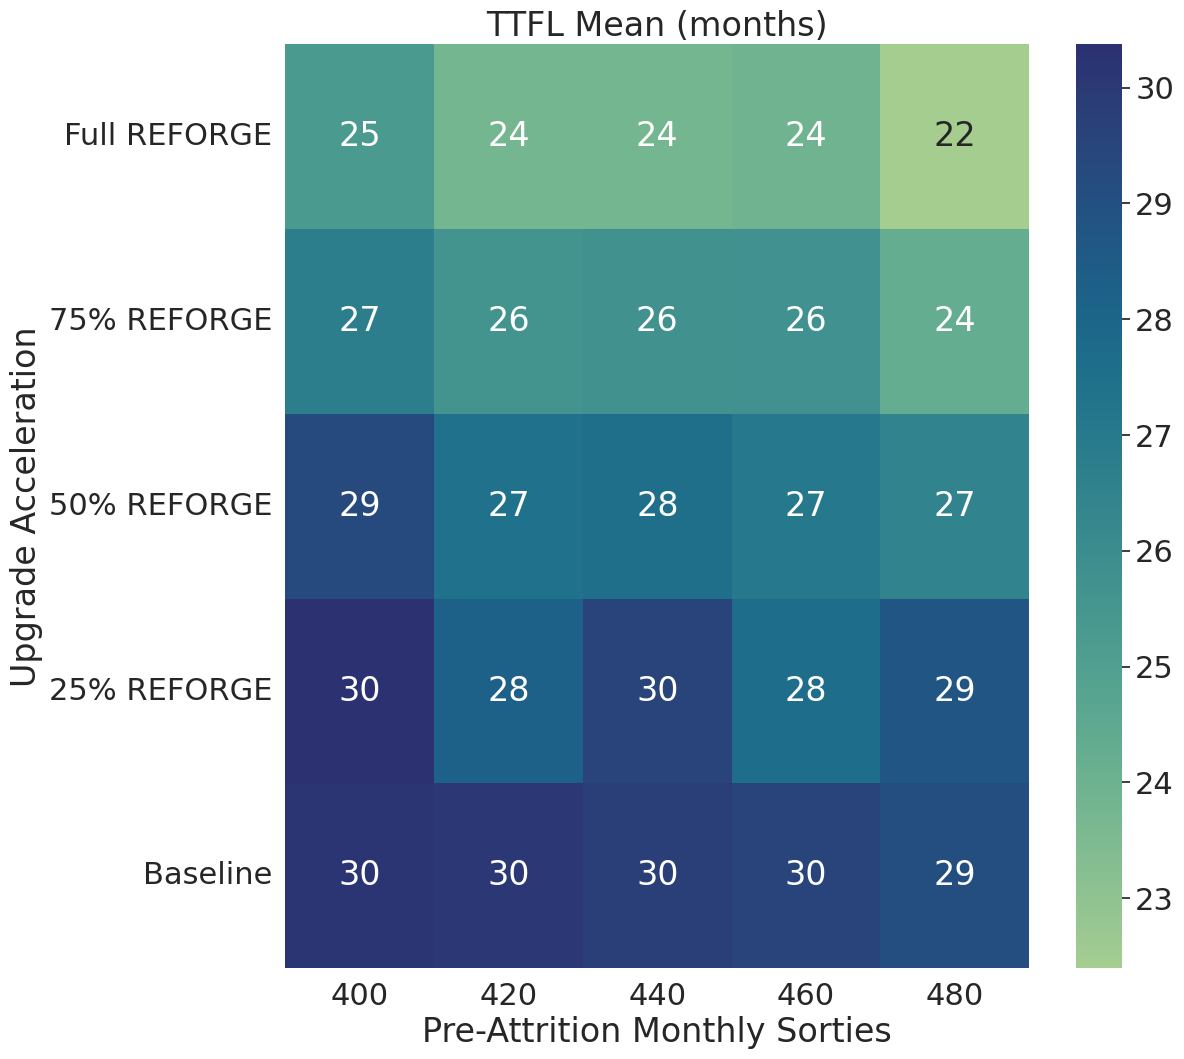

In [71]:
sns.heatmap(ttfl_matrix, annot=True, cmap='crest', linewidth=0)
plt.title('TTFL Mean (months)')
plt.ylabel('Upgrade Acceleration')

Text(102.24999999999997, 0.5, 'Upgrade Acceleration')

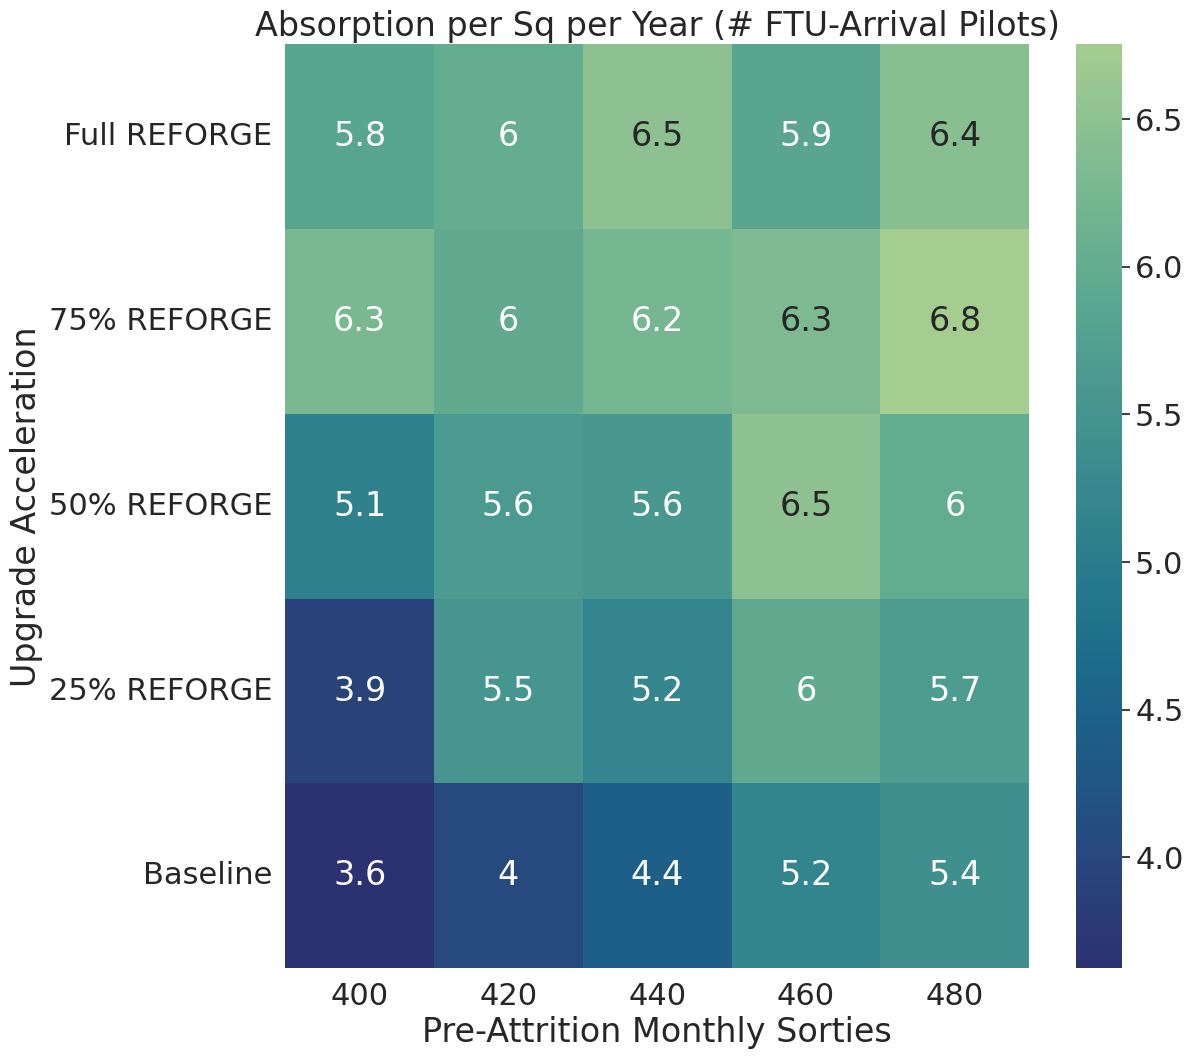

In [72]:
sns.heatmap(absorption_matrix, annot=True, cmap='crest_r', linewidth=0)
plt.title('Absorption per Sq per Year (# FTU-Arrival Pilots)')
plt.ylabel('Upgrade Acceleration')

# Outputs

In [73]:
###
# Cases loop by acceleration, then by sortie generation.
# 0: 400 sorties, Baseline
# 1: 400 sorties, 25% REFORGE
# 2: 400 sorties, 50% REFORGE
# 3: 400 sorties, 75% REFORGE
# 4: 400 sorties, Full REFORGE
# 5: 420 sorties, Baseline
# etc.
###
case_num = 0
many = runs_by_case[case_num]['all_runs']

## Sortie Generation and Execution

Text(0.5, 1.0, 'Unit Sortie Generation and Execution by Type')

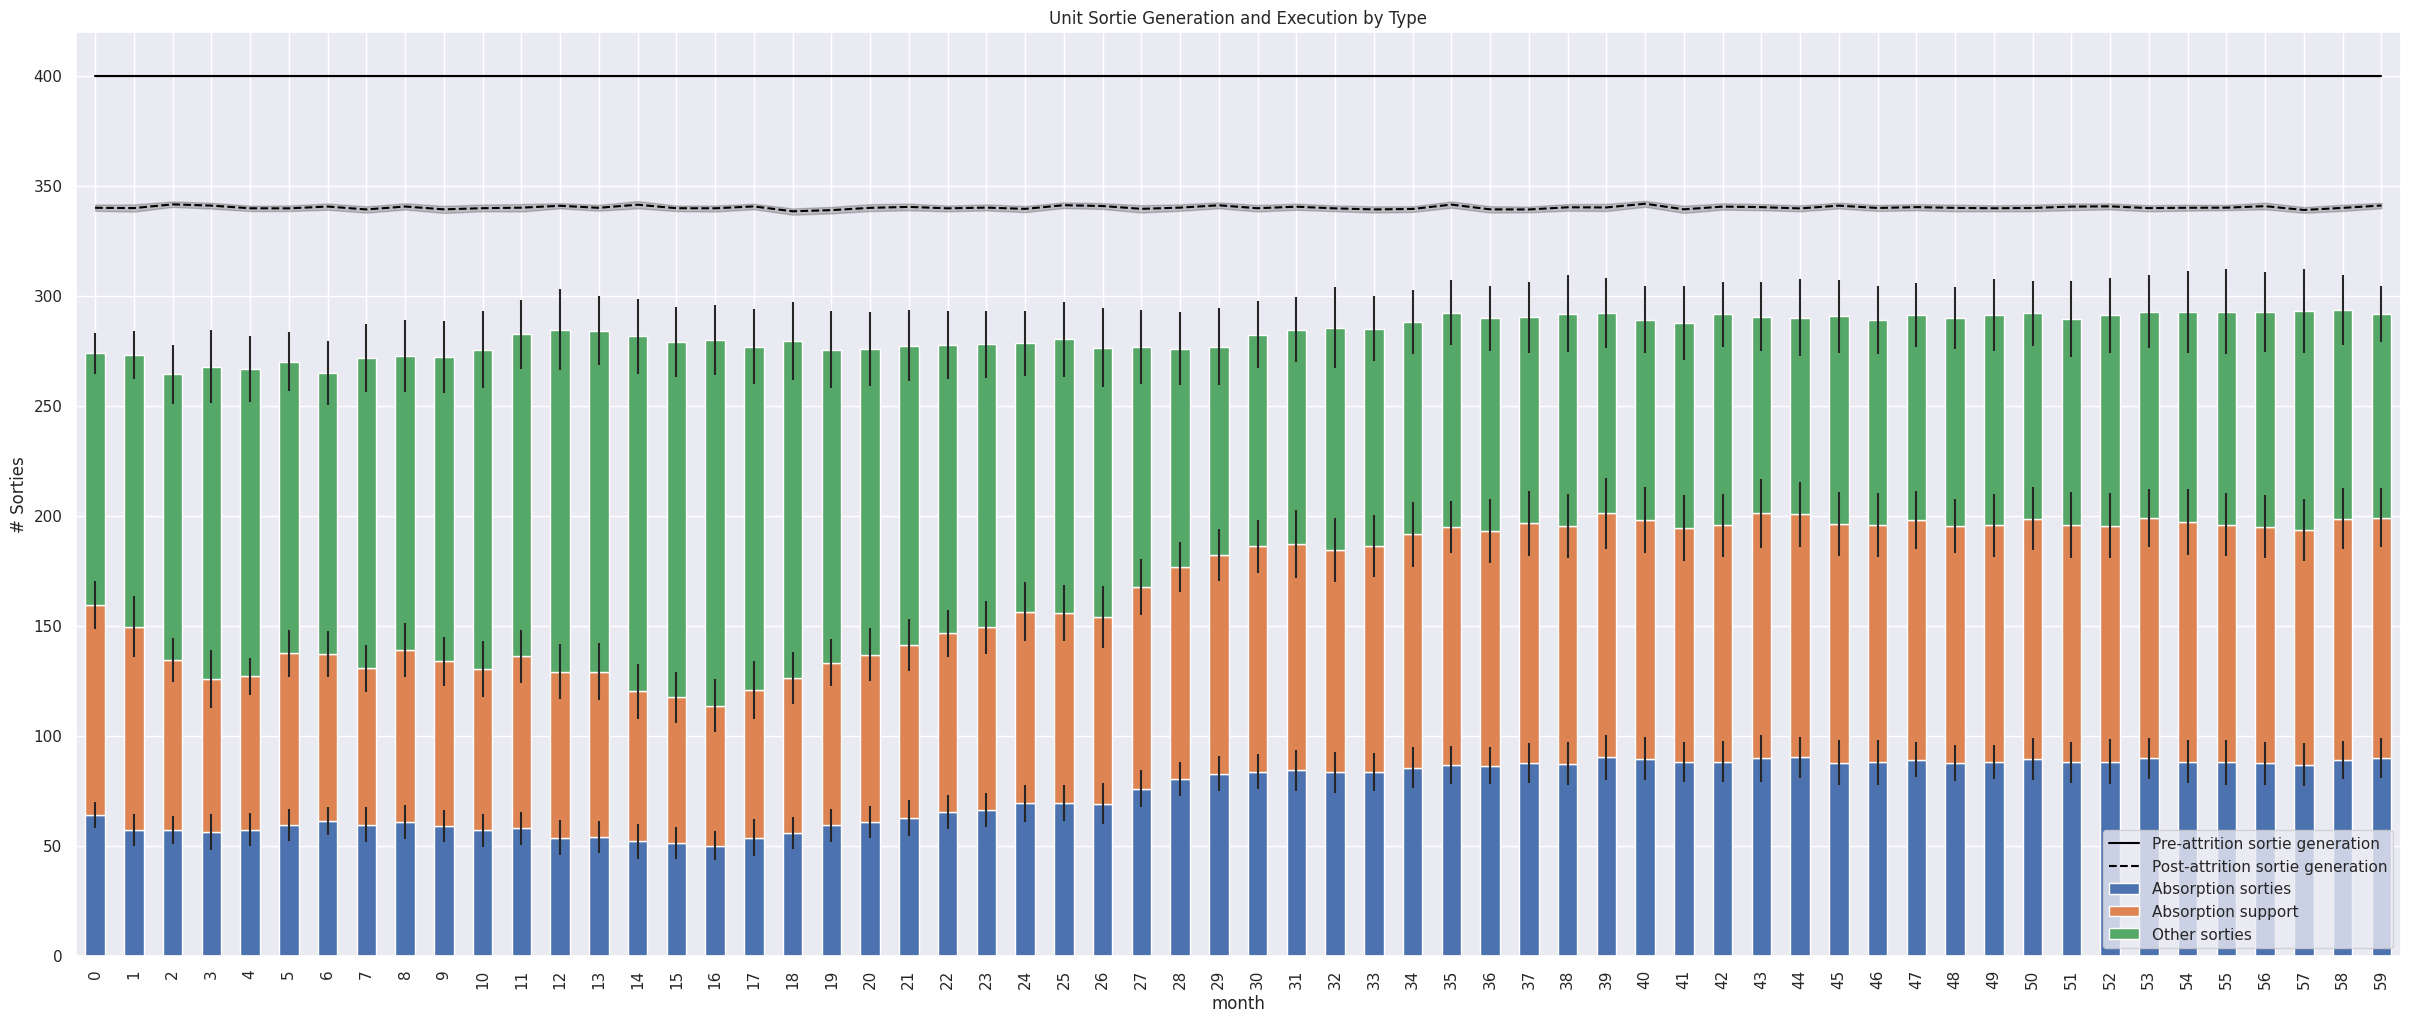

In [74]:
sorties_df = pd.DataFrame(chain.from_iterable([run['monthly']['SORTIES_FLOWN'] for run in many]))
sorties_df['month'] = np.tile(np.arange(months_per_run), num_runs)
sorties_df = sorties_df.groupby('month')

means = sorties_df.mean()
errs = sorties_df.std().fillna(0)

plt.rcParams['figure.figsize'] = (30, 12)
sns.set_theme()
ax = sns.lineplot(data=sorties_df.obj, x='month', y='Pre-attrition', label='Pre-attrition sortie generation', color='black')
sns.lineplot(data=sorties_df.obj, x='month', y='Post-attrition', ax=ax, label='Post-attrition sortie generation', color='black', linestyle='dashed')
means.iloc[:, :3].plot.bar(yerr=errs, stacked=True, ax=ax)
ax.set_ylabel('# Sorties')
ax.set_title('Unit Sortie Generation and Execution by Type')

## Upgrades

<ipython-input-75-7219e835ee5d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  intervals.set_yticklabels([f'{x:.0%}' for x in intervals.get_yticks()])


nth tour          374
initial            14
initial WG          3
initial WG/2FL      3
Name: Source, dtype: int64

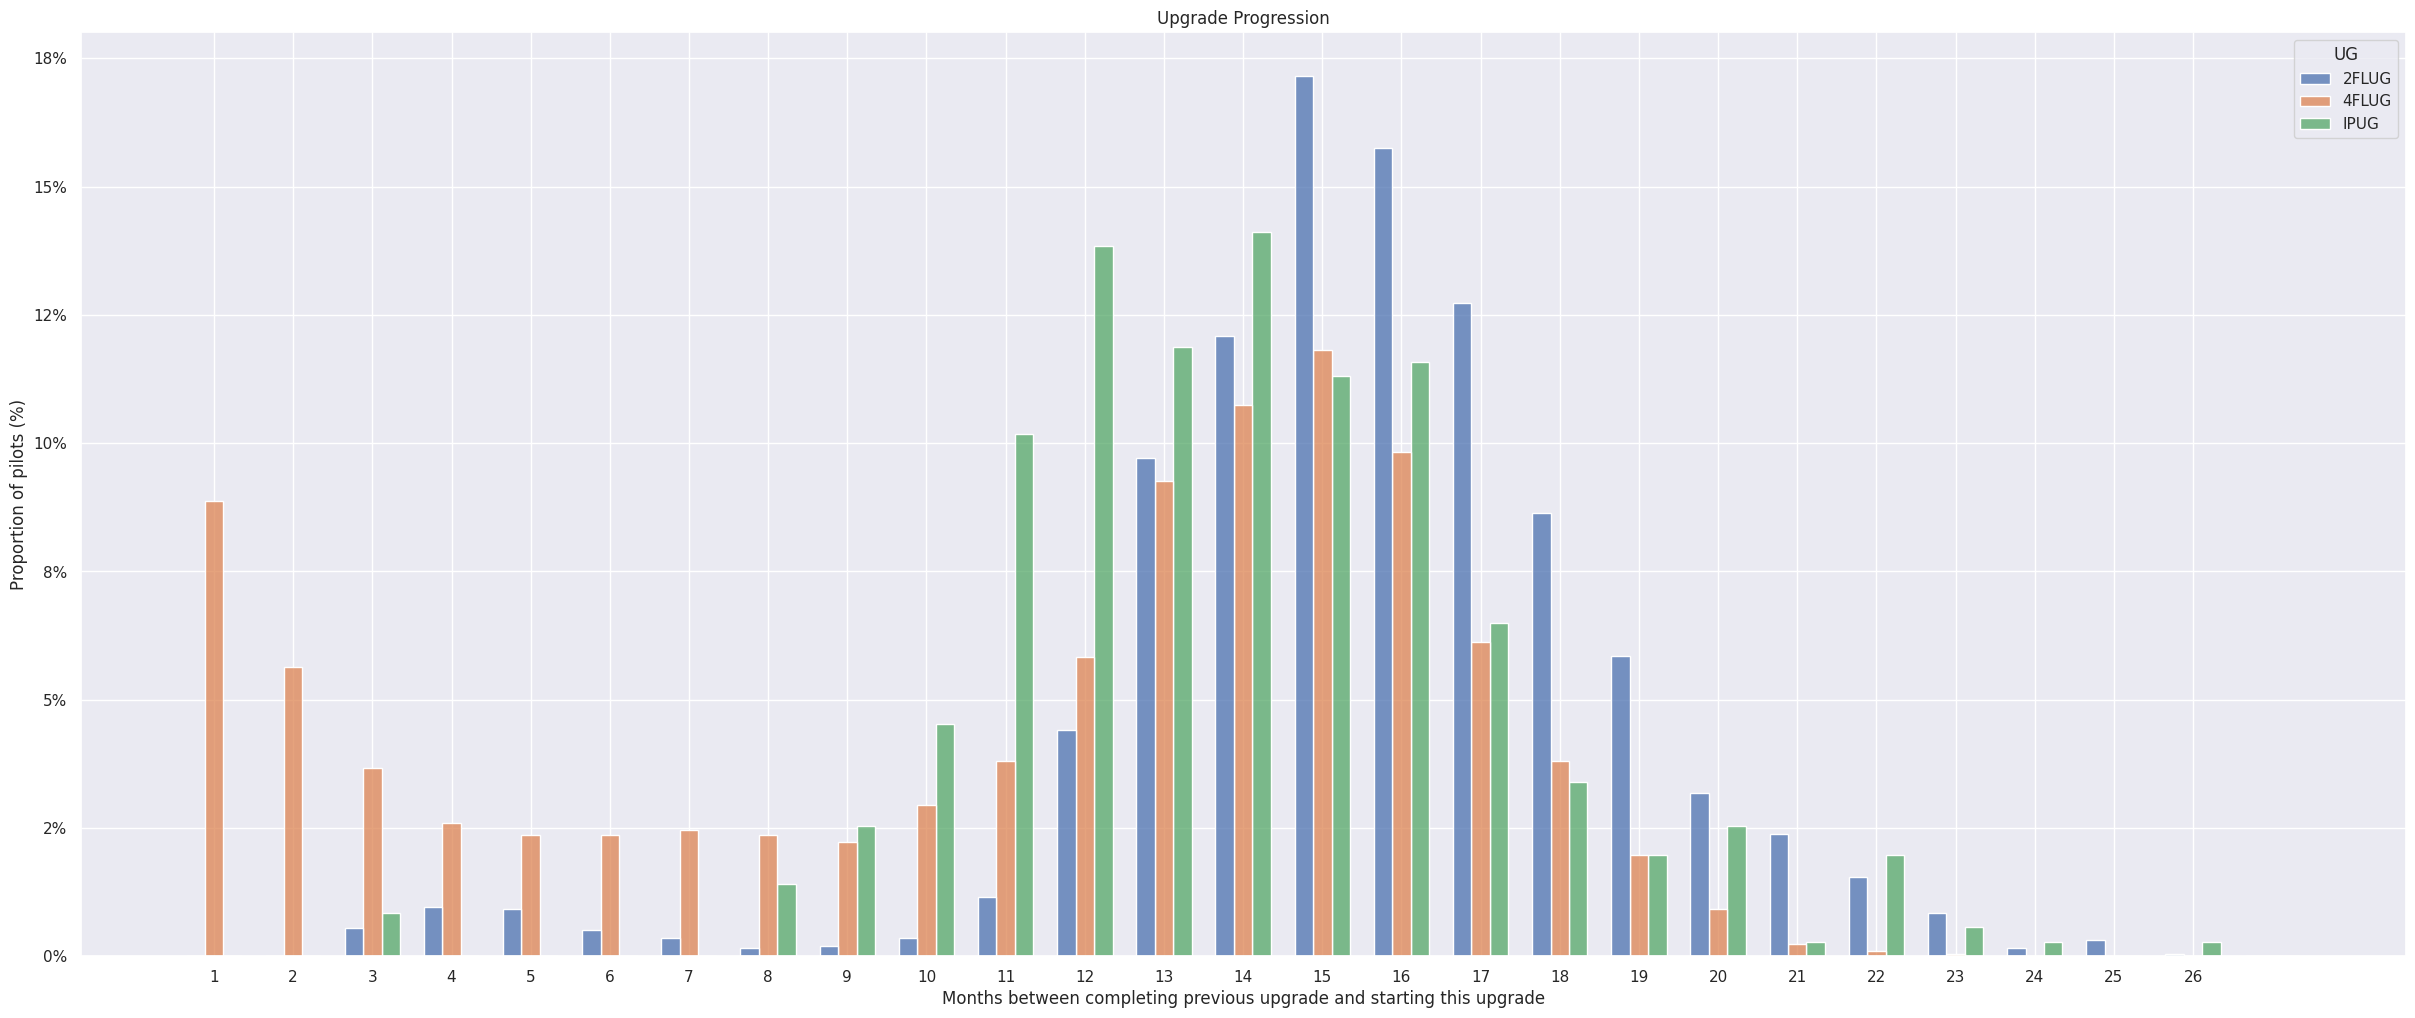

In [75]:
ttugs = []
for i, run in enumerate(many):
  [t.update({'run': i}) for t in run['pilot']['UG_COMPLETIONS']]
  ttugs.extend(run['pilot']['UG_COMPLETIONS'])

ttug_df = pd.DataFrame(ttugs)

ug_starts = ttug_df.sort_values(['run', 'PID', 'Start month'])
ug_starts['end month'] = ug_starts['Start month'] + ug_starts['TTUG']
ug_starts['prev_ug_end'] = ug_starts.groupby(['run','PID'])['end month'].shift(1)
ug_starts['months_between_ugs'] = ug_starts['Start month'] - ug_starts['prev_ug_end']
#ug_starts = ug_starts.dropna(subset='months_between_ugs')

ug_order = ['MQT', '2FLUG', '4FLUG', 'IPUG']
no_nans = ug_starts.dropna(subset='months_between_ugs')
intervals = sns.histplot(data=no_nans, x='months_between_ugs', hue='UG', binrange=(min(no_nans.months_between_ugs), max(no_nans.months_between_ugs) + 1), discrete=True, multiple='dodge', stat='proportion', shrink=0.7, common_norm=False, hue_order=ug_order[1:])
intervals.set_xticks(np.arange(min(no_nans.months_between_ugs), max(no_nans.months_between_ugs) + 1))
intervals.set_yticklabels([f'{x:.0%}' for x in intervals.get_yticks()])
intervals.set_xlabel('Months between completing previous upgrade and starting this upgrade')
intervals.set_ylabel('Proportion of pilots (%)')
intervals.set_title('Upgrade Progression')

no_nans.loc[no_nans['months_between_ugs'] <= 3]['Source'].value_counts()

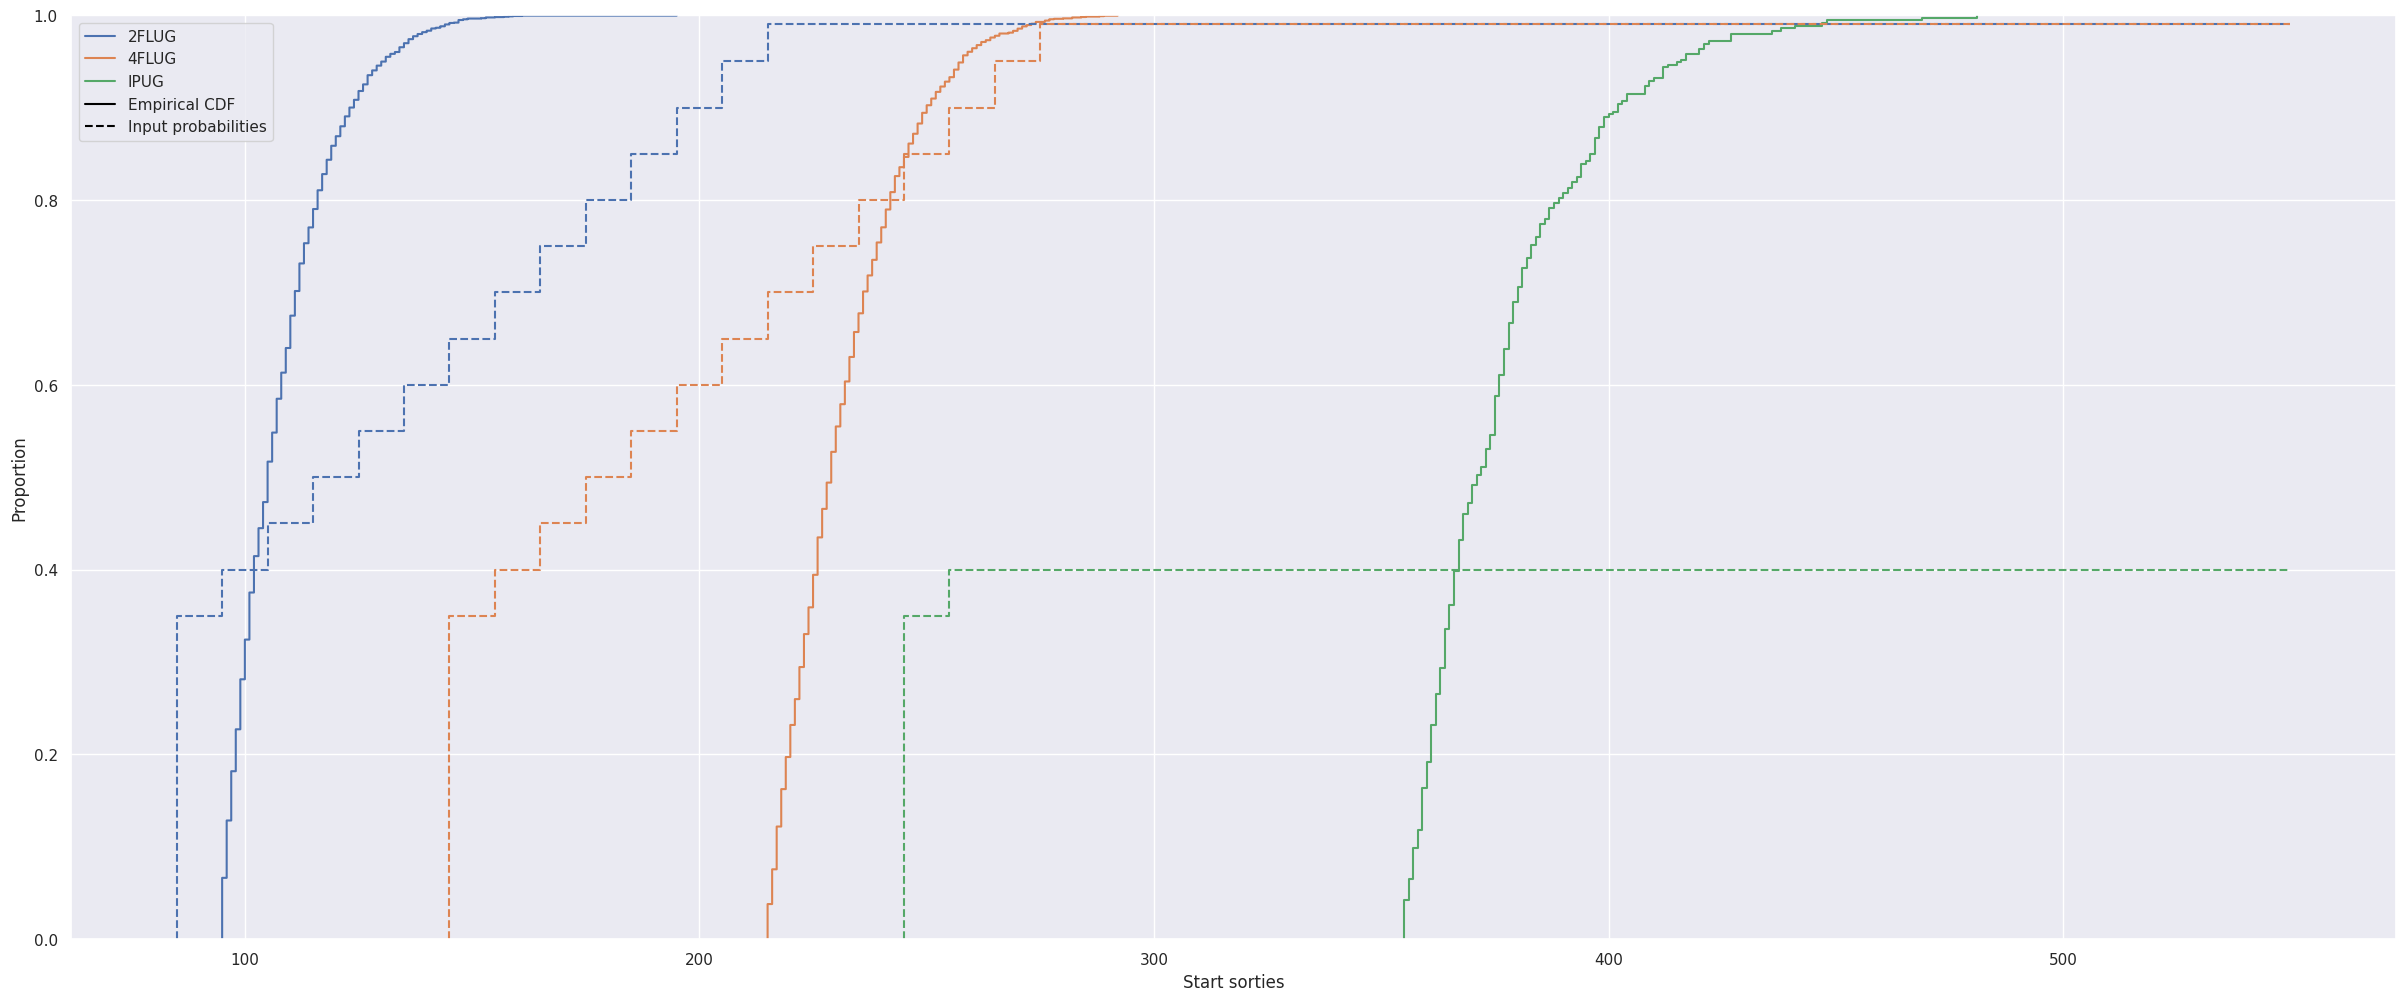

In [76]:
sortie_enrols = sns.ecdfplot(data=no_nans, x='Start sorties', hue='UG', hue_order=ug_order[1:], legend=False)

def make_ug_step_function(ug, min_sorties, min_prob, sortie_chunk, prob_chunk, max_prob):
  results = [{'sorties': min_sorties - .001, 'prob': 0, 'ug': ug}]
  prob = min_prob
  sorties = min_sorties
  while prob < max_prob + prob_chunk:
      results.append({'sorties': sorties, 'prob': min(prob, max_prob), 'ug': ug})
      sorties += sortie_chunk
      prob += prob_chunk
  results.append({'sorties': max(ug_starts['Start sorties']), 'prob': max_prob, 'ug': ug})

  return results

tbl = make_ug_step_function('2FLUG', min_mds_sorties_2flug, enrolment_prob_at_minimum_2flug, sortie_chunk_size_2flug, enrolment_prob_increment_per_chunk_2flug, enrolment_prob_max_2flug)
tbl.extend(make_ug_step_function('4FLUG', min_mds_sorties_4flug, enrolment_prob_at_minimum_4flug, sortie_chunk_size_4flug, enrolment_prob_increment_per_chunk_4flug, enrolment_prob_max_4flug))
tbl.extend(make_ug_step_function('IPUG', min_mds_sorties_ipug, enrolment_prob_at_minimum_ipug, sortie_chunk_size_ipug, enrolment_prob_increment_per_chunk_ipug, enrolment_prob_max_ipug))

input_probs = pd.DataFrame(tbl)

sns.lineplot(data=input_probs, x='sorties', y='prob', hue='ug', drawstyle='steps-pre', ax=sortie_enrols, linestyle='dashed', hue_order=ug_order[1:])

solid = mlines.Line2D([], [], color='black', label='Empirical CDF')
dashed = mlines.Line2D([], [], color='black', label='Input probabilities', linestyle='--')

h, l = sortie_enrols.get_legend_handles_labels()
h.extend([solid, dashed])
sortie_enrols.legend(handles=h)


<ipython-input-77-b69aae9801ba>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])


Text(0.5, 0, 'MDS Sorties')

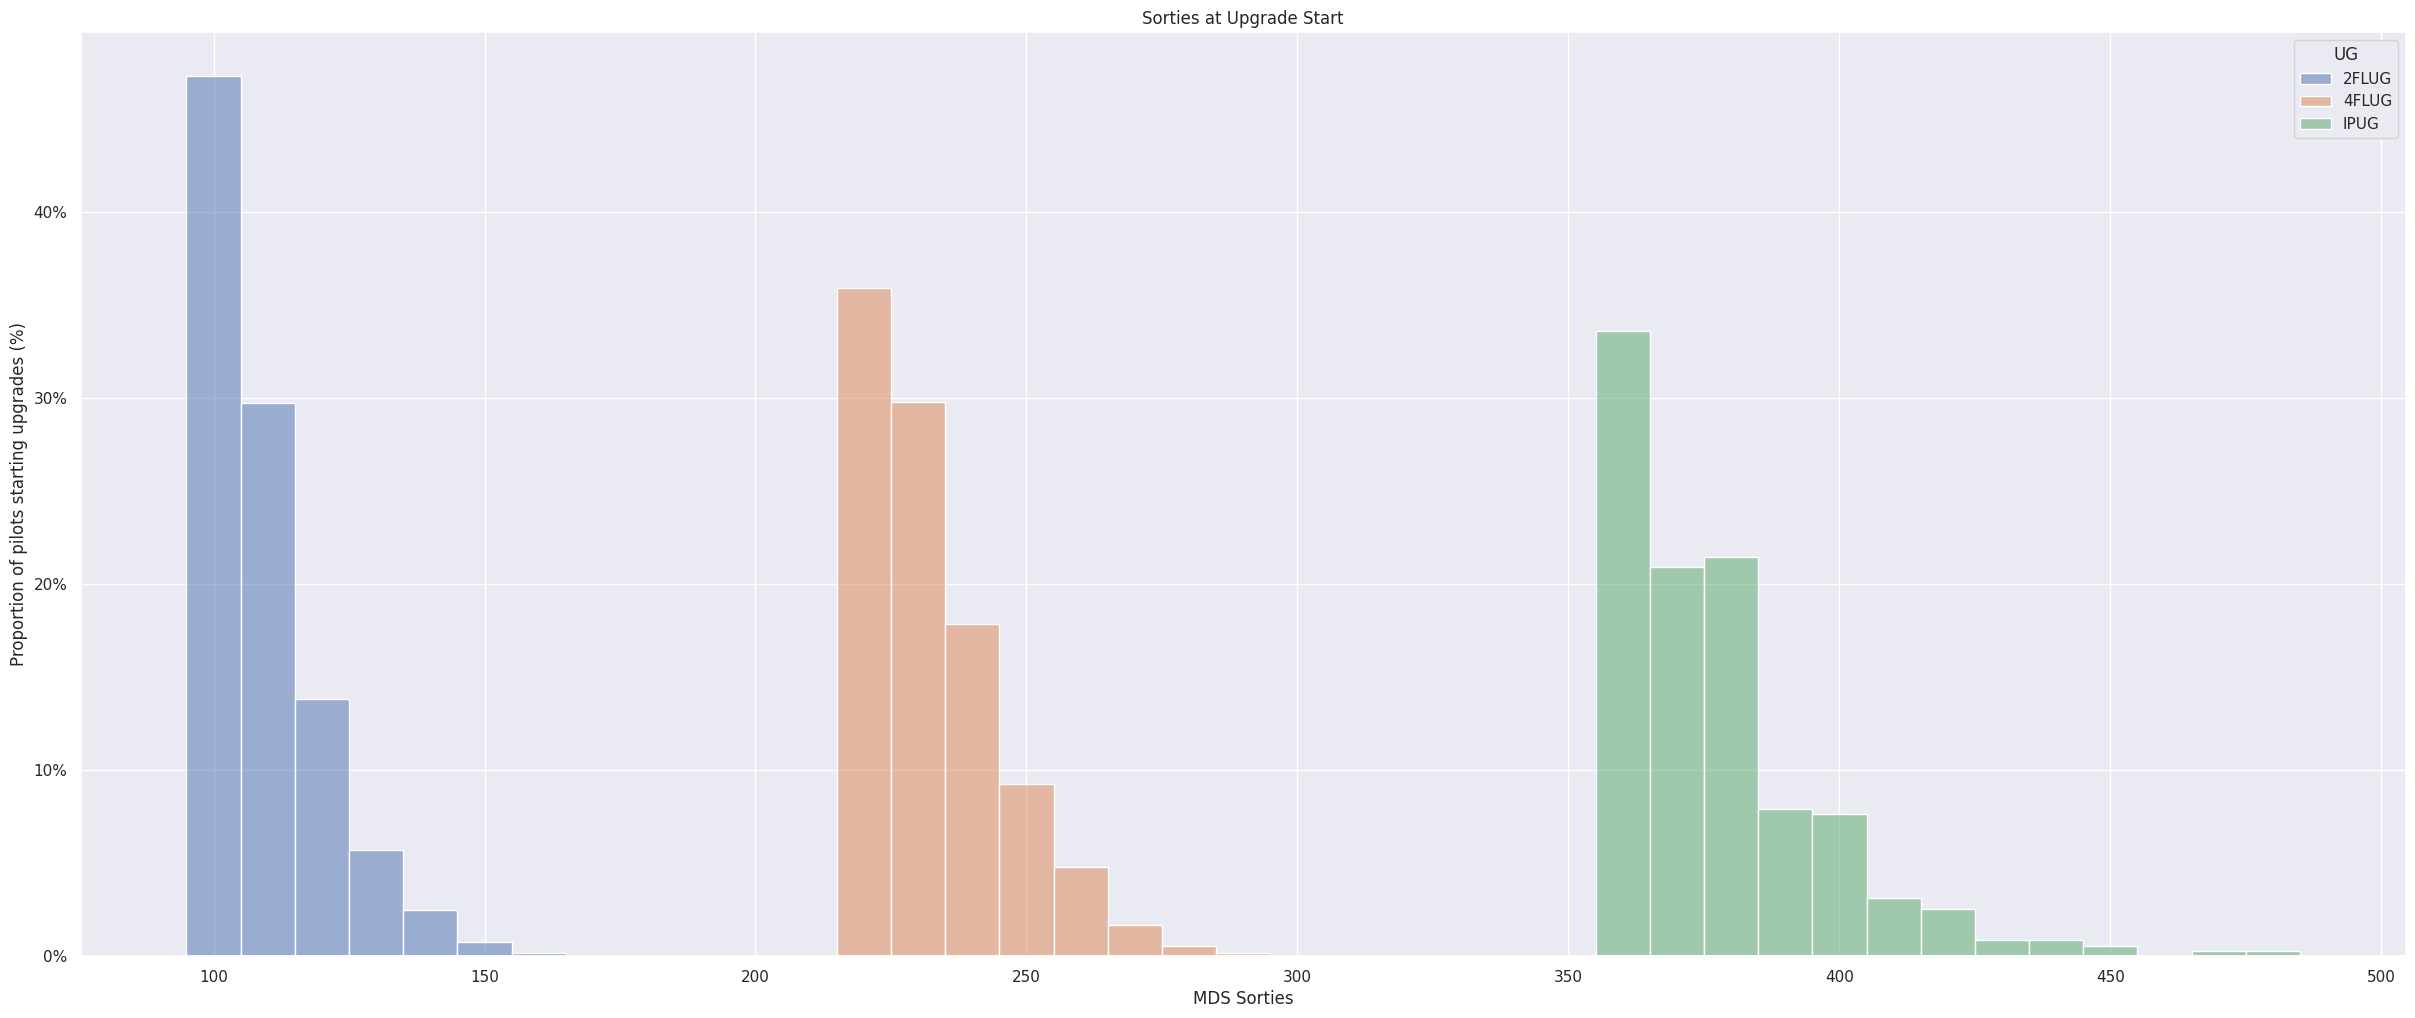

In [77]:
ax = sns.histplot(data=no_nans, x='Start sorties', hue='UG', stat='proportion', common_norm=False, hue_order=ug_order[1:], binwidth=10)
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
ax.set_title('Sorties at Upgrade Start')
ax.set_ylabel('Proportion of pilots starting upgrades (%)')
ax.set_xlabel('MDS Sorties')

<ipython-input-78-5b4fb1d98d74>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ttug_hist.set_yticklabels([f'{x:.0%}' for x in ttug_hist.get_yticks()])


Text(0.5, 1.0, 'Upgrade completion durations')

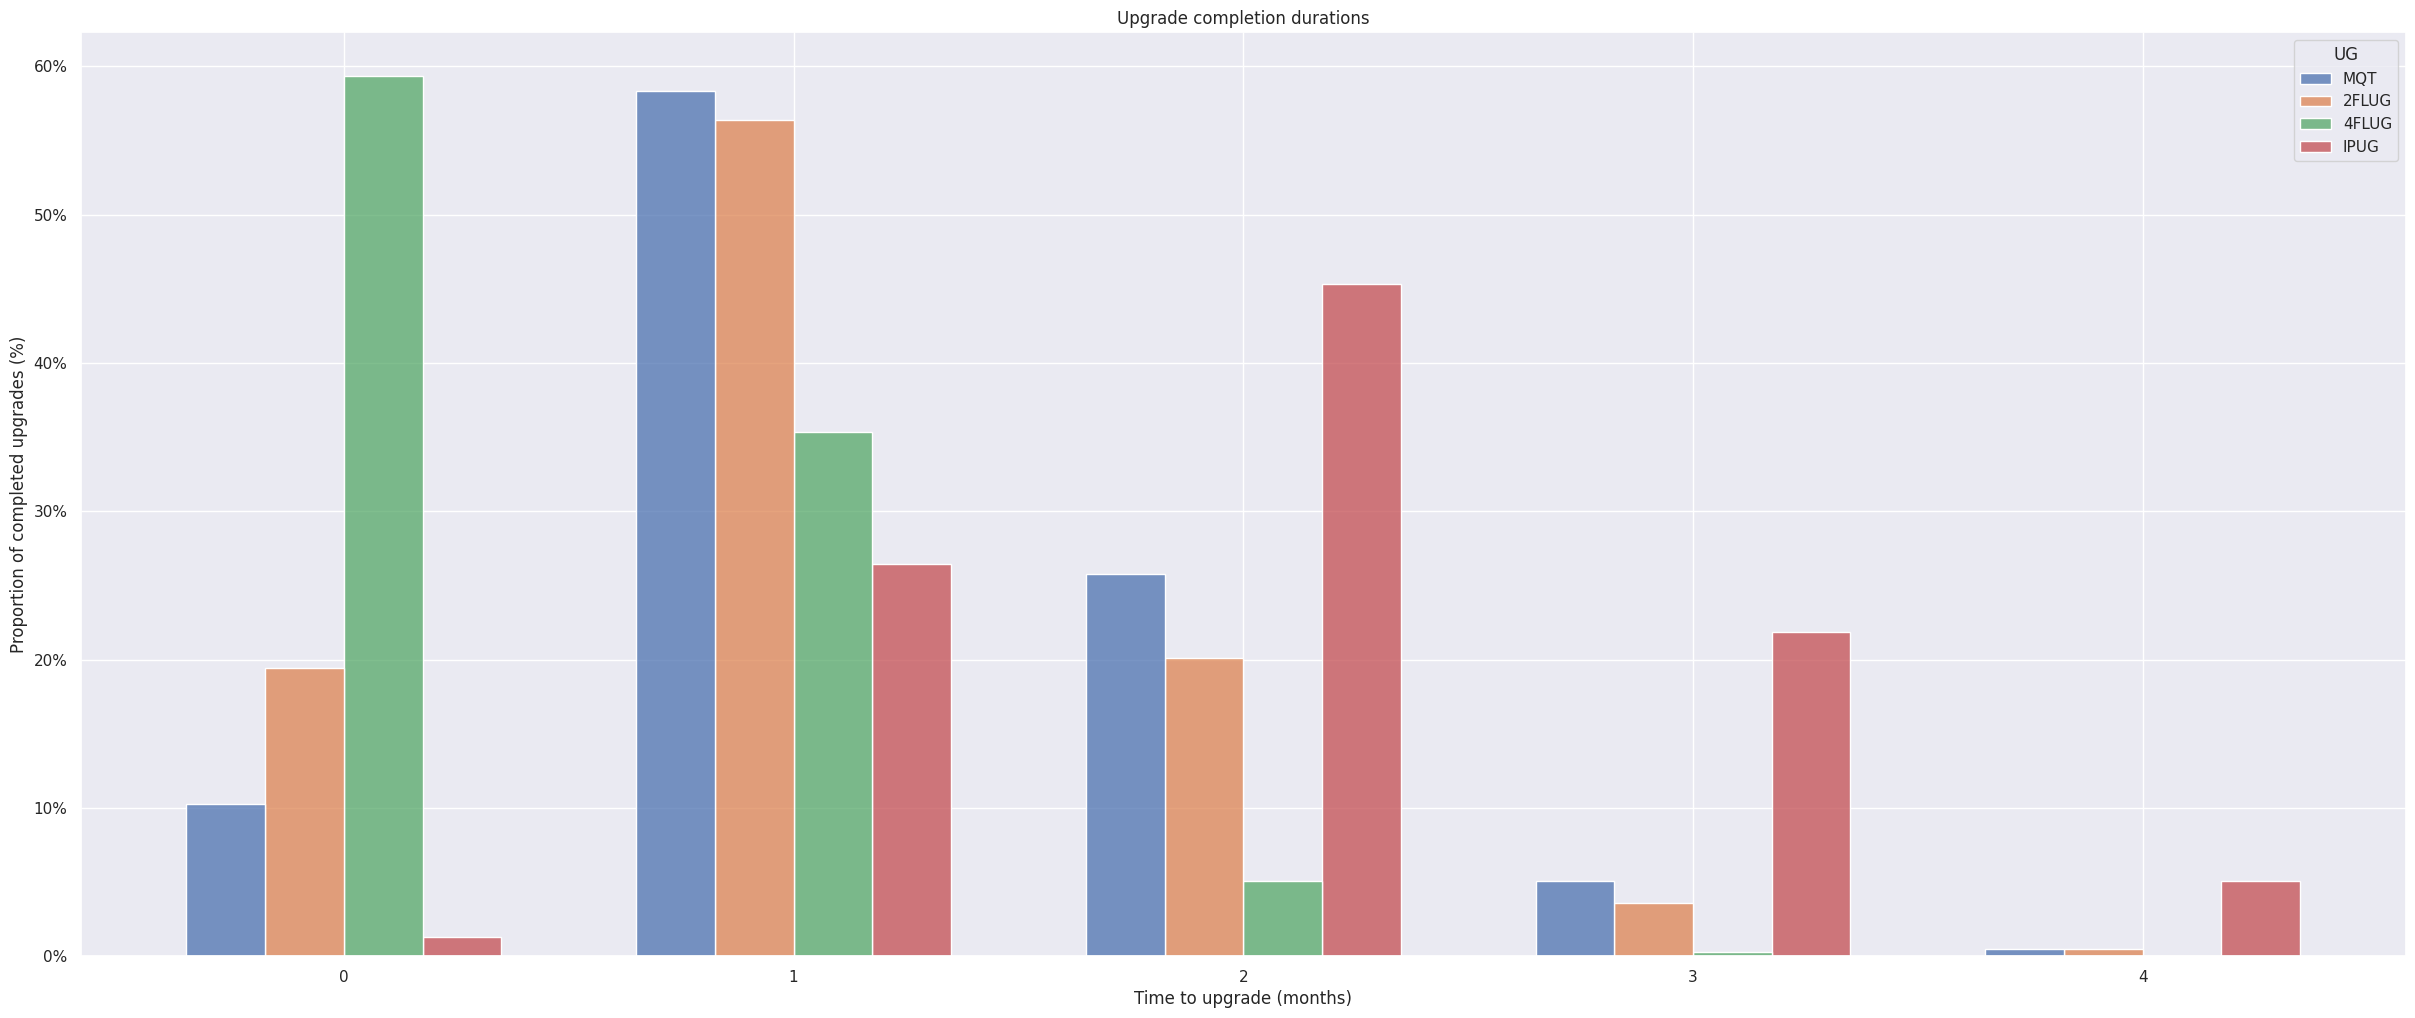

In [78]:
ttug_hist = sns.histplot(data=ttug_df, x='TTUG', hue='UG', binrange=(0,4), discrete=True, multiple='dodge', stat='proportion', shrink=0.7, common_norm=False, hue_order=ug_order)
ttug_hist.set_xlabel('Time to upgrade (months)')
ttug_hist.set_ylabel('Proportion of completed upgrades (%)')
ttug_hist.set_yticklabels([f'{x:.0%}' for x in ttug_hist.get_yticks()])
ttug_hist.set_title('Upgrade completion durations')

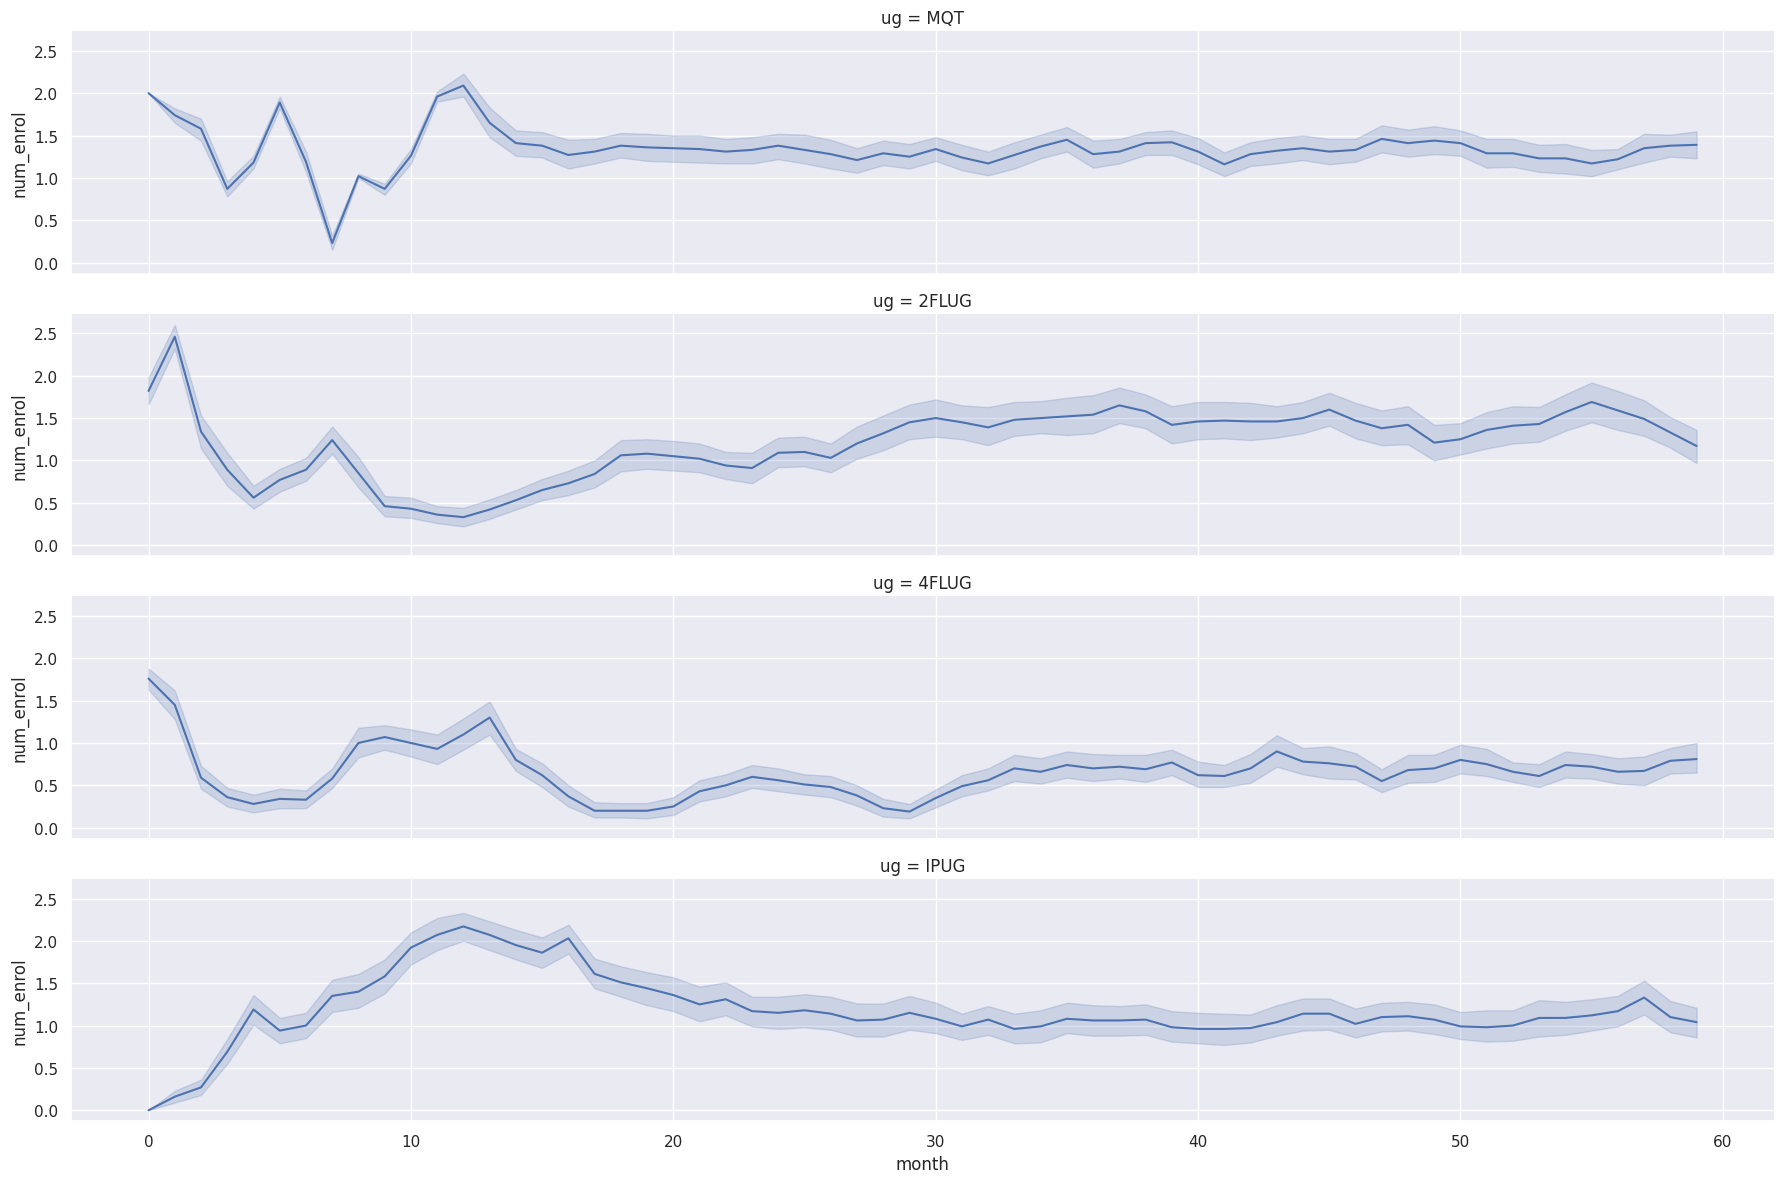

In [79]:
ug_sizes = pd.DataFrame(chain.from_iterable([run['monthly']['NUM_IN_UGS'] for run in many])).fillna(0).loc[:, ug_order]
ug_sizes['month'] = np.tile(np.arange(months_per_run), num_runs)

ug_long = ug_sizes.melt(id_vars='month', var_name='ug', value_name='num_enrol')
ug_long

g = sns.FacetGrid(ug_long, row='ug', aspect=6)
g.map(sns.lineplot, 'month', 'num_enrol')

## Composition by Qualification

<ipython-input-80-94eef6be3452>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])


[Text(0, -0.1, '-10%'),
 Text(0, 0.0, '0%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.20000000000000004, '20%'),
 Text(0, 0.30000000000000004, '30%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.5000000000000001, '50%')]

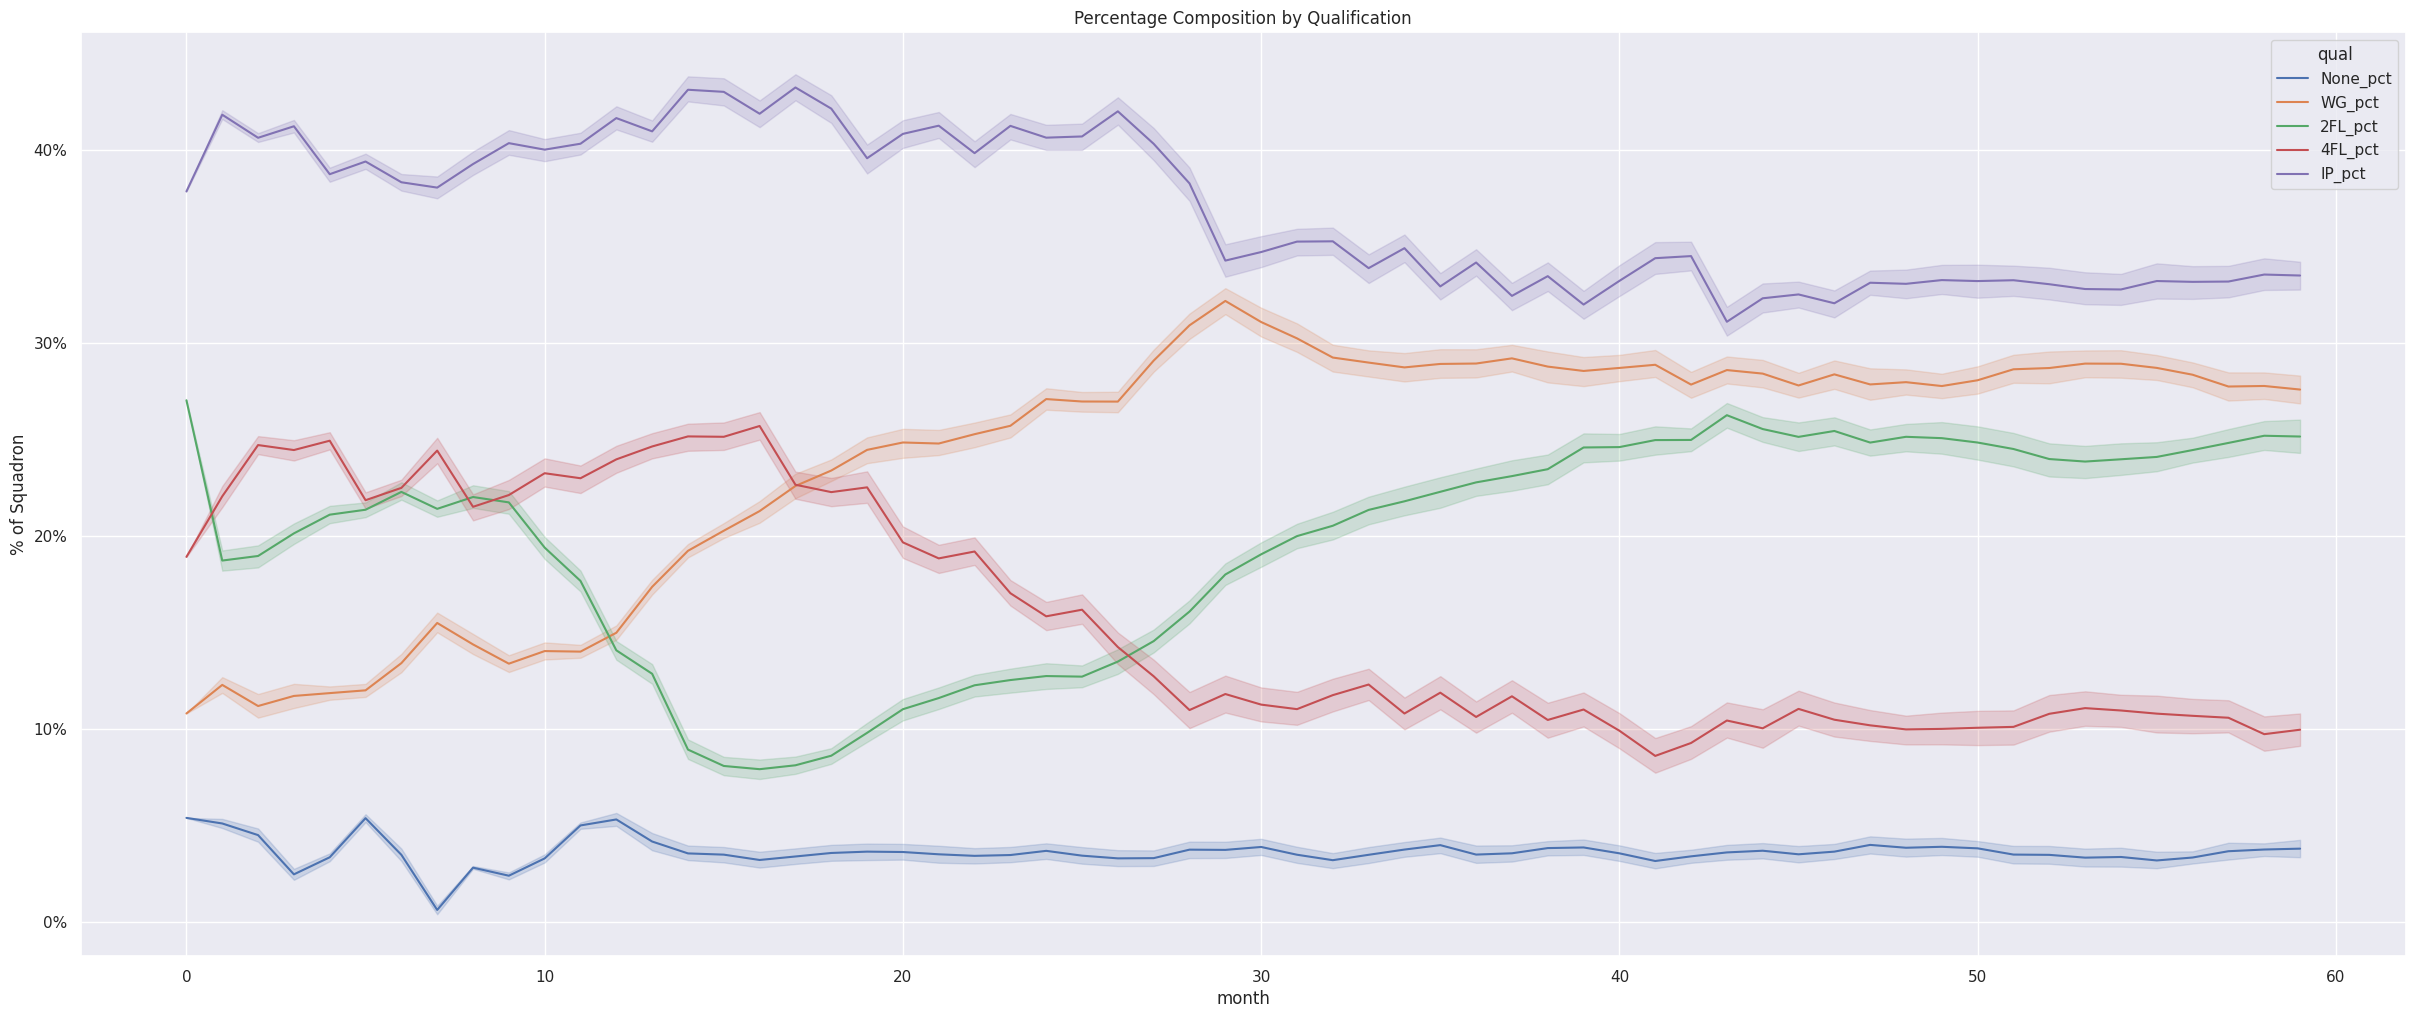

In [80]:
qual_order = ['None'] + [s.award for s in f22_syllabi.values()]
df = pd.DataFrame(chain.from_iterable([run['monthly']['NUM_BY_QUAL'] for run in many])).fillna(0).rename(columns={'': 'None'})#
df['total'] = df.sum(axis=1)
df['month'] = np.tile(np.arange(months_per_run), num_runs)

for qual in qual_order:
    df[f'{qual}_pct'] = df[qual] / df['total']

pcts_df = df.loc[:, 'month':].melt(id_vars='month', var_name='qual', value_name='pct')

nums_df = df.loc[:, :'month'].drop(columns=['total'])#.melt(id_vars='month', var_name='qual', value_name='num')

# df['total'] = np.sum(df['None'])
# df.melt(id_vars='month', var_name='qual', value_name='num')
#quals_df
# df = pd.concat([df, df.quals.apply(pd.Series)], axis=1).rename(columns = {'' : 'None'}).drop('quals', axis=1).fillna(0)
# quals_df = df.groupby('month').mean()

# for qual in ['None', 'WG', '2FL', '4FL', 'IP']:
#     quals_df[f'{qual}_pct'] = quals_df[qual] / quals_df.sum(axis=1)

# quals_df

sns.set_theme()
fig, ax = plt.subplots()
sns.lineplot(data=pcts_df, ax=ax, x='month', y='pct', hue='qual')
ax.set_title('Percentage Composition by Qualification')
ax.set_ylabel('% of Squadron')
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])

## Manning and Experience

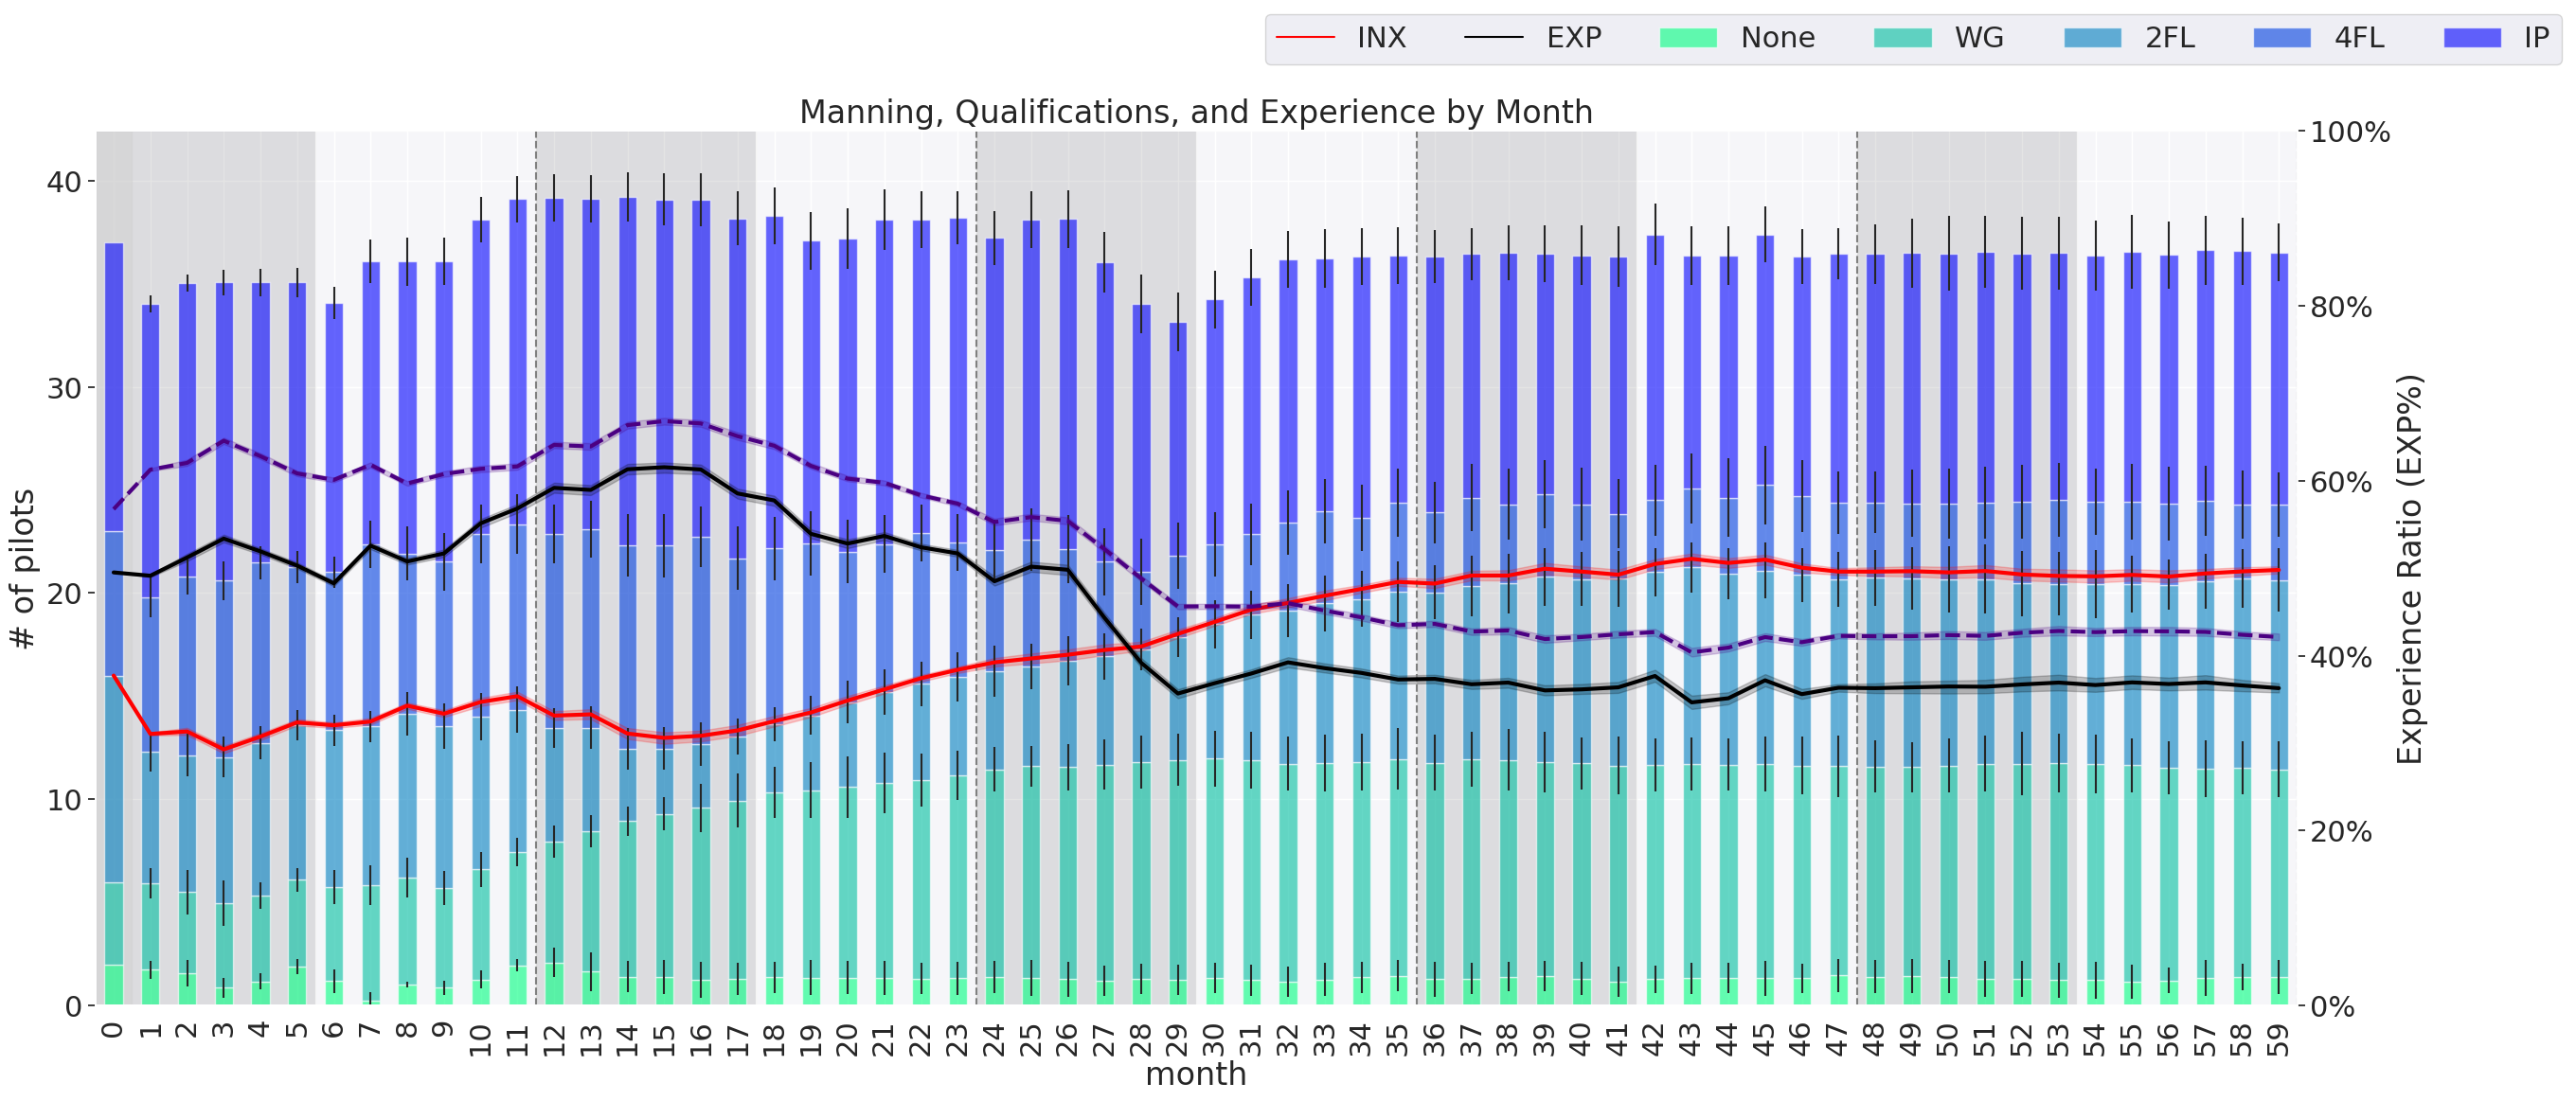

In [81]:
df = pd.DataFrame(chain.from_iterable([run['monthly']['NUM_BY_EXP'] for run in many])).fillna(0).rename(columns = {False: 'INX', True: 'EXP'})                                                                                                   
#                                                                                                         melt(var_name='month', value_name='exp_numbers')
# df = pd.concat([df, df.exp_numbers.apply(pd.Series)], axis=1).rename(columns = {False: 'INX', True: 'EXP'}).drop('exp_numbers', axis=1)

df['ratio'] = df['EXP'] / df[['EXP', 'INX']].sum(axis=1)
df['month'] = np.tile(np.arange(months_per_run), num_runs)

exp_df = df.melt(id_vars=['month', 'ratio'], value_vars=['INX', 'EXP'])

means = nums_df.groupby('month').mean()
std = nums_df.groupby('month').std().fillna(0)

sns.set_theme()
sns.set(font_scale=2)
fig, ax = plt.subplots()
for year in range(1, int((months_per_run / 12))+1):
    ax.axvline(year*12 - 0.5, linestyle='--', lw=1.5, c='gray')
    start = (year-1)*12 - 0.5
    ax.axvspan(start, start+6, color='lightgray', alpha=0.6)
    ax.axvspan(start+6, start+12, color='white', alpha=0.6)
ax.axvspan(-0.5, 0.5, color='lightgray', alpha=0.6)
#means[qual_order].plot(kind='bar', stacked=True, yerr=std, colormap='winter_r', alpha=0.6, ax=ax)
means[qual_order].plot(kind='bar', stacked=True, yerr=std, colormap='winter_r', alpha=0.6, ax=ax)
sns.lineplot(data=exp_df, x='month', y='value', hue='variable', ax=ax, linewidth=3, palette=['red', 'black'])
ax2 = ax.twinx()
sns.lineplot(data=exp_df, x='month', y='ratio', ax=ax2, color='indigo', linestyle='--', linewidth=3, alpha=1, legend=False)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylabel('# of pilots')
ax2.set_ylabel('Experience Ratio (EXP%)')
ax.set_title('Manning, Qualifications, and Experience by Month')
ax2.grid(False)
ax2.set_yticklabels([f'{x:.0%}' for x in ax2.get_yticks()])
ax.get_legend().set_visible(False)
ax.set_ylim(bottom=0)
handles, _ = ax.get_legend_handles_labels()
fig.legend(ncols=len(handles) + 1)

## Sorties per Crewmember per Month (SCM)

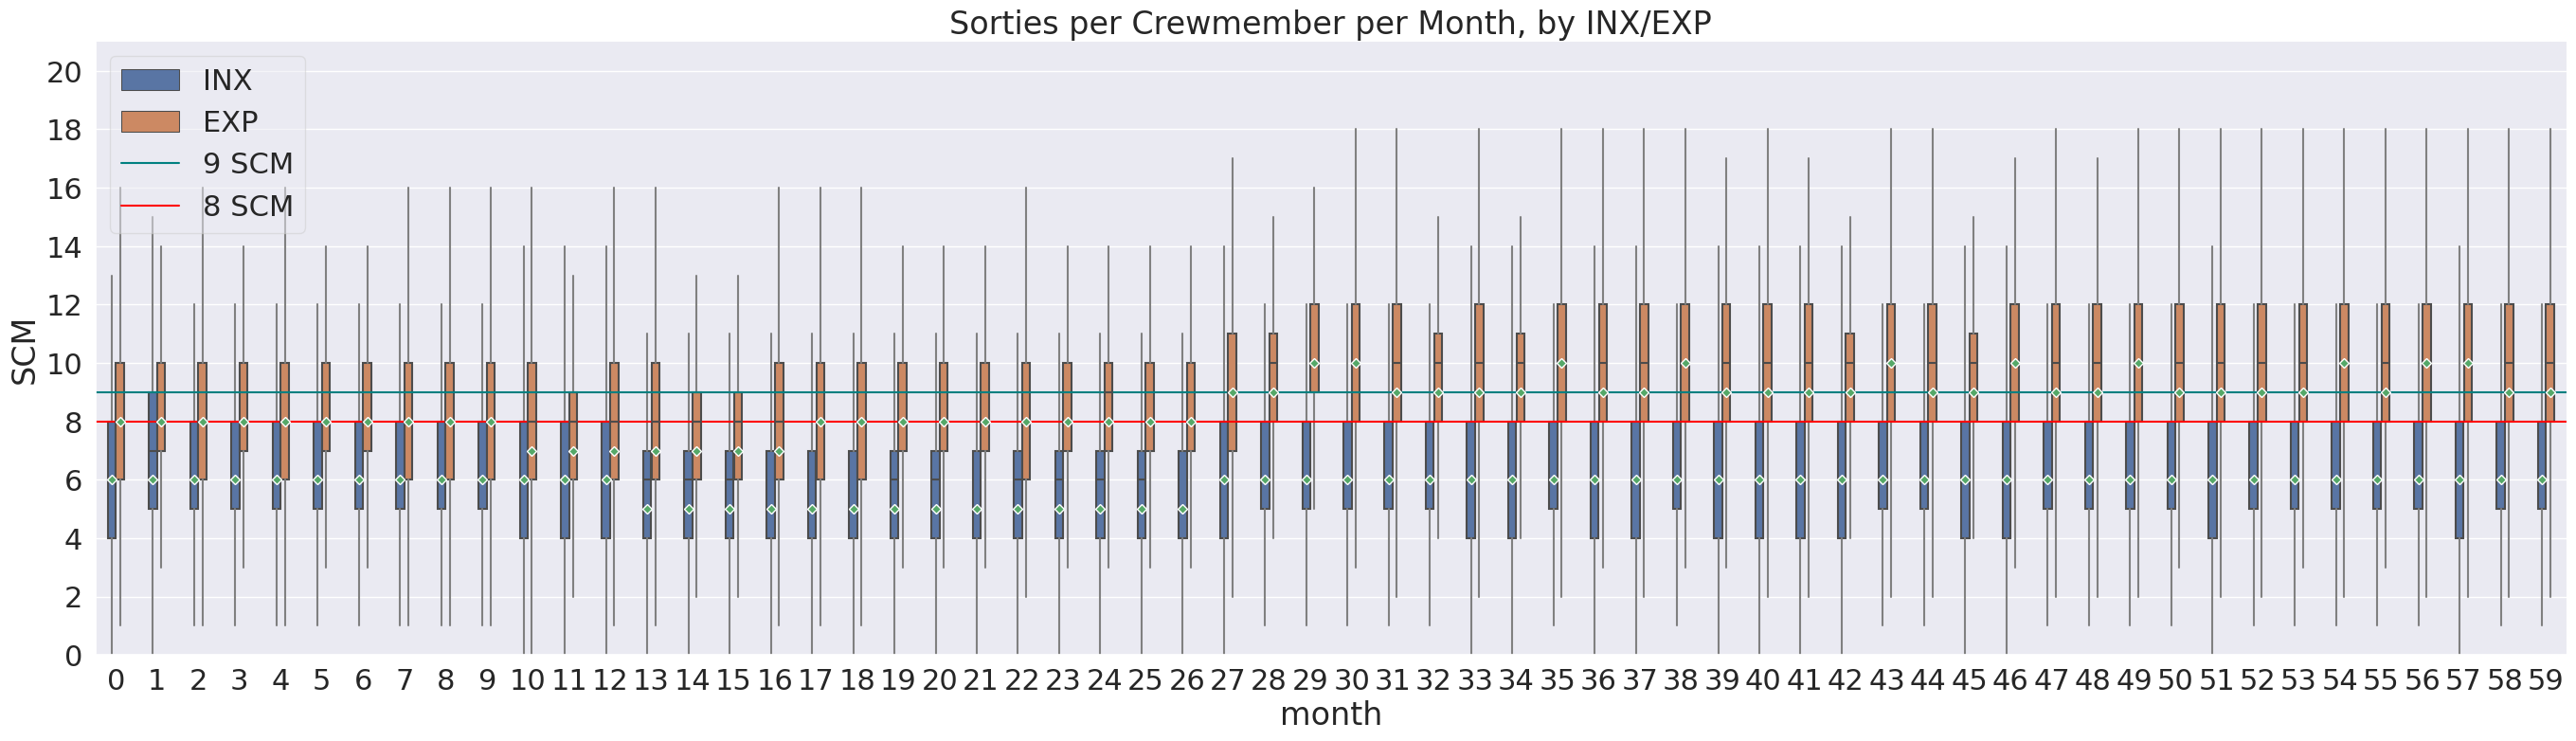

In [82]:
# df = pd.DataFrame(chain.from_iterable([run['monthly']['SCM_INX'] for run in many])).melt(var_name='month', value_name='SCM')
# df['experience'] = 'INX'
# # df = pd.concat([df, pd.DataFrame(chain.from_iterable([run['monthly']['SCM_EXP'] for run in many])).melt(var_name='month', value_name='SCM').assign(experience='EXP')])
# # df
df = pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_INX']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM')
df['experience'] = 'INX'
df = pd.concat([df, pd.DataFrame(np.array([np.array([month for month in run['monthly']['SCM_EXP']], dtype='object') for run in many])).melt(var_name='month', value_name='SCM').assign(experience='EXP')])
scm_df = df.explode('SCM')
scm_df

box = sns.catplot(data=scm_df, y='SCM', x='month', hue='experience', kind='box', width=0.4, showmeans=True, showcaps=False, showfliers=False, meanprops={'marker': 'D', 'markeredgecolor': 'white', 'markersize': 5}, whiskerprops={'color': 'grey'}, height=8, aspect=3.5, legend=False)
# == Code below modified from https://stackoverflow.com/questions/63038011/assign-color-of-mean-markers-while-using-seaborn-hue
num_artists = 2*len(nums_df)
num_lines = len(box.ax.lines)
lines_per_artist = num_lines // num_artists
marker_colors = ['cyan', 'magenta']*(num_artists//2)
for i in range(num_artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = marker_colors[i]
    # box.ax.lines[i*lines_per_artist + j].set_edgecolor(col)
    # box.ax.lines[i*lines_per_artist + j].set_facecolor('None')
    # set the marker colors of the corresponding "lines" to the same color
    for j in range(lines_per_artist):
        box.ax.lines[i * lines_per_artist + j].set_markerfacecolor(col)
        box.ax.lines[i * lines_per_artist + j].set_markeredgecolor('white')
# ==
box.ax.axhline(9, color='teal', label='9 SCM')
box.ax.axhline(8, color='red', label='8 SCM')
box.ax.set_yticks(range(0, 21, 2))
box.ax.set_ylim(0, 21)
box.ax.set_title('Sorties per Crewmember per Month, by INX/EXP')
plt.legend(framealpha=0.5)
plt.show()

#  ax = flows[['net_first', 'net_nth']].plot(kind='bar')
#  ax.axhline(0, color='black')
#  ax.set_xlabel('month')
#  ax.set_ylabel('net gain/loss by first v. nth tour')

#  flows[['first_cum', 'nth_cum']].plot(kind='line', ax=ax)

## Absorption: Time to Flight Lead (TTFL) and Yearly Capacity

<ipython-input-83-8fa7a14623ce>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])


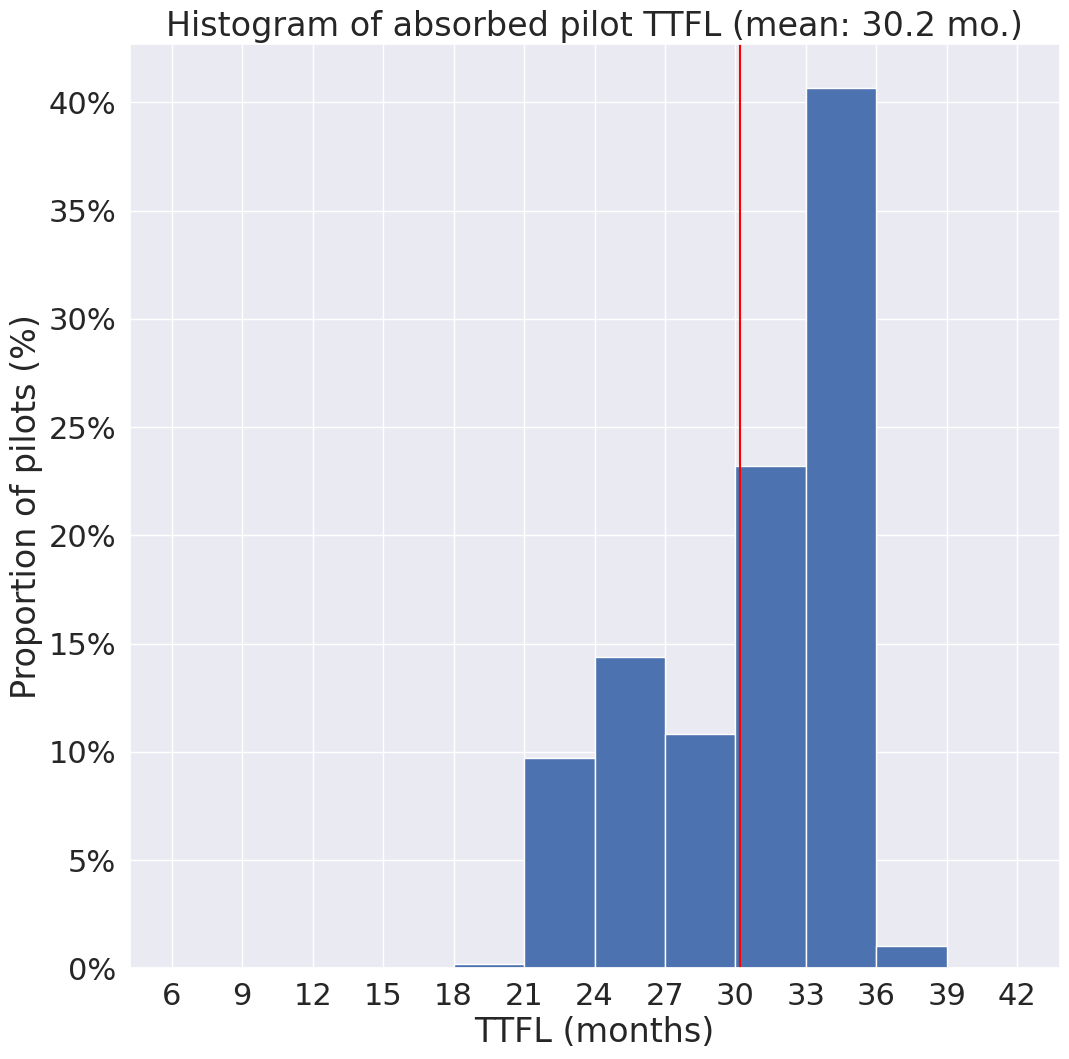

In [83]:
df = pd.DataFrame([row for run in many for row in run['pilot']['TTFL'] if row['Absorbable']])
df['EXP year'] = df['EXP month'].floordiv(12)
absorbed_df = df

plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
absorbed_df['TTFL'].plot.hist(bins=range(6, 45, 3), weights = np.ones_like(absorbed_df['TTFL']) / len(absorbed_df['TTFL']), ax=ax)
ax.axvline(absorbed_df['TTFL'].mean(), color='red')
ax.set_xlabel('TTFL (months)')
ax.set_ylabel('Proportion of pilots (%)')
ax.set_title(f'Histogram of absorbed pilot TTFL (mean: {absorbed_df["TTFL"].mean():.1f} mo.)')
ax.set_xticks(range(6, 45, 3))
ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
plt.show()

<Axes: title={'center': 'Absorption by Year (mean: 3.6 pilots per year)'}, xlabel='EXP year'>

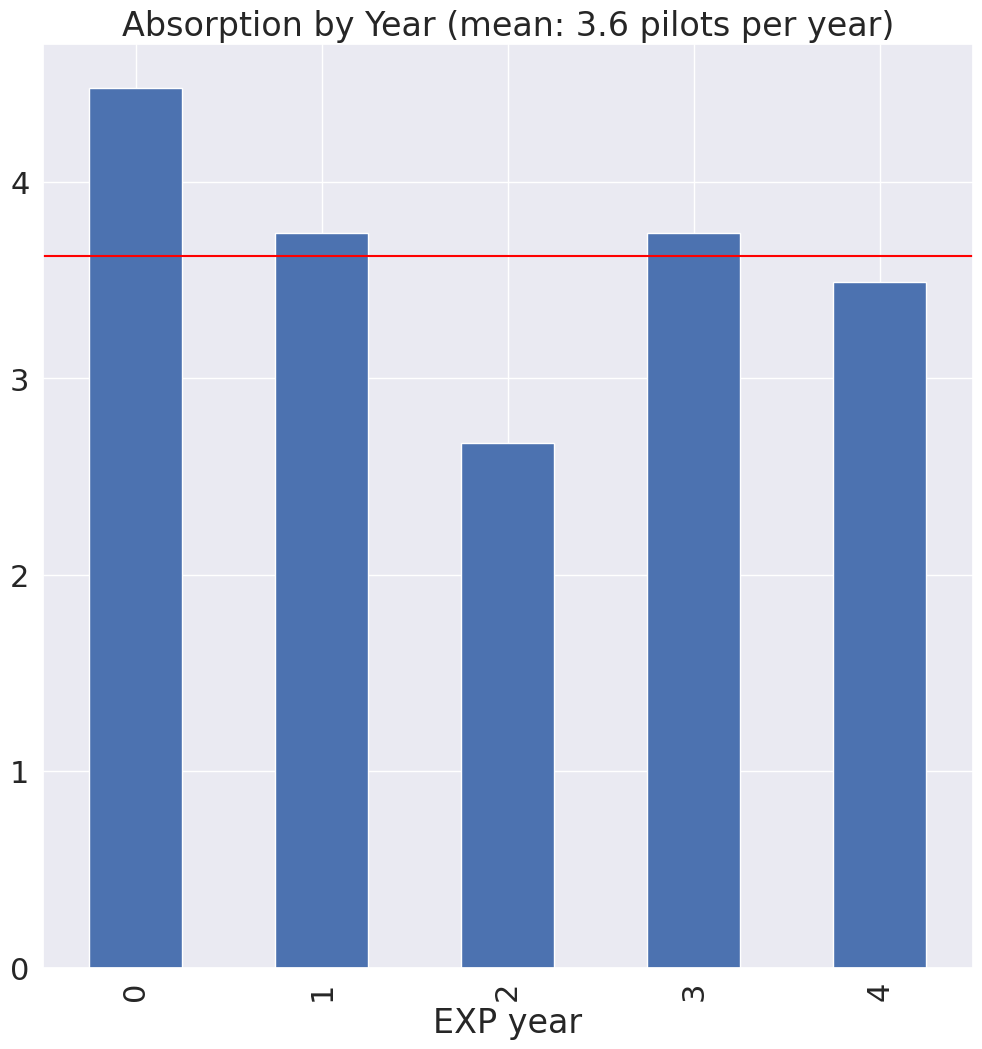

In [84]:
per_year = absorbed_df.groupby('EXP year').size() / num_runs
mean_absorption = per_year[:int(months_per_run/12)].mean()

plt.rcParams['figure.figsize'] = (12, 12)
fig, ax = plt.subplots()
ax.axhline(mean_absorption, color='red')
ax.set_title(f'Absorption by Year (mean: {mean_absorption:.1f} pilots per year)')
per_year[:int(months_per_run/12)].plot(ax=ax, kind='bar')